# Air Quality Index (AQI) Forecasting Pipeline

This notebook implements a machine learning pipeline to forecast hourly AQI values for the next 24 hours based on historical air quality and weather data.

## 1. Import Libraries and Dependencies

First, we'll import all the necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Standard library imports
import os
import sys
import warnings
from datetime import datetime, timedelta

# Data manipulation imports
import numpy as np
import pandas as pd
import pytz

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
%matplotlib inline

# Machine learning imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time series and forecasting models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Suppress warnings
warnings.filterwarnings('ignore')

# Add utils directory to path for importing TimescaleDBUtil
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils.timescaledb_util import TimescaleDBUtil

## 2. Data Loading and Initial Exploration

We'll load data from the TimescaleDB database where the merged AQI and weather data is stored.

In [2]:
# Initialize connection to TimescaleDB
ts_db = TimescaleDBUtil()
if not ts_db.connect():
    raise ConnectionError("Failed to connect to TimescaleDB")
    
print("Connected to TimescaleDB successfully.")

Connected to TimescaleDB successfully.


In [3]:
# Function to retrieve data for a specific time range
def get_historical_data(days=90, locations=None):
    """
    Retrieve historical AQI and weather data for the specified number of days.
    
    Args:
        days: Number of days of historical data to retrieve
        locations: List of locations to filter by, or None for all locations
    
    Returns:
        DataFrame with historical data
    """
    # Calculate the start date (N days ago)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    # Format dates for SQL query
    start_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_date.strftime('%Y-%m-%d %H:%M:%S')
    
    # Create location filter if specified
    location_filter = ""
    if locations and isinstance(locations, list) and len(locations) > 0:
        location_list = ", ".join([f"'{loc}'" for loc in locations])
        location_filter = f"AND location IN ({location_list})"
    
    # SQL query to get the data
    query = f"""
        SELECT 
            time,
            location,
            "PM2.5",
            "PM10",
            "NO2",
            "SO2",
            "O3",
            "CO",
            temperature,
            pressure,
            humidity,
            wind_speed,
            wind_direction,
            weather_icon,
            dew
        FROM 
            merge_aqi_weather
        WHERE 
            time BETWEEN '{start_str}' AND '{end_str}'
            {location_filter}
        ORDER BY 
            time ASC, location
    """
    
    # Execute the query
    result = ts_db.execute_query(query)
    if result is None:
        print("No data returned from query")
        return pd.DataFrame()
        
    print(f"Retrieved {len(result)} records spanning from {start_str} to {end_str}")
    return result

# Get the last 90 days of data for all locations
historical_data = get_historical_data(days=90)

# Display the first few rows
display(historical_data.head())

# Basic information about the dataset
print(f"Dataset shape: {historical_data.shape}")
print(f"Unique locations: {historical_data['location'].nunique()}")
print(f"Date range: {historical_data['time'].min()} to {historical_data['time'].max()}")

Retrieved 10653 records spanning from 2025-02-22 08:43:44 to 2025-05-23 08:43:44


,time,location,PM2.5,PM10,NO2,SO2,O3,CO,temperature,pressure,humidity,wind_speed,wind_direction,weather_icon,dew
0,2025-03-07,46 Lưu Quang Vũ,64.0,NaN,45.0,NaN,2.0,9.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0
1,2025-03-07,An Khánh,69.0,21.0,7.0,NaN,NaN,5.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0
2,2025-03-07,Hai BaTrung,56.0,17.0,27.0,NaN,NaN,4.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0
3,2025-03-07,Minh Khai - Bắc Từ Liêm,NaN,42.0,NaN,1.0,5.0,NaN,15.0,1022.0,62.95,5.8,70.0,10d,8.0
4,2025-03-07,Vân Hà,78.0,27.0,4.0,NaN,NaN,3.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0


Dataset shape: (10653, 15)
Unique locations: 6
Date range: 2025-03-07 00:00:00 to 2025-05-23 07:00:00


In [4]:
# Check for missing values
missing_values = historical_data.isna().sum()
missing_percentage = (missing_values / len(historical_data)) * 100

# Combine into a DataFrame for better visualization
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

display(missing_df)

# Display basic statistics
display(historical_data.describe())

,Missing Values,Percentage
time,0,0.000000
location,0,0.000000
PM2.5,602,5.650990
PM10,801,7.519009
NO2,1178,11.057918
SO2,5937,55.730780
O3,5354,50.258143
CO,716,6.721111
temperature,0,0.000000
pressure,0,0.000000


,time,PM2.5,PM10,NO2,SO2,O3,CO,temperature,pressure,humidity,wind_speed,wind_direction,dew
count,10653,10051.000000,9852.000000,9475.000000,4716.000000,5299.000000,9937.000000,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000
mean,2025-04-14 01:08:50.216840192,90.501741,40.656770,20.867124,0.672392,7.470183,5.327010,24.348040,1011.420429,76.222962,4.757358,141.256557,19.792834
min,2025-03-07 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,999.000000,24.220000,0.000000,0.000000,4.000000
25%,2025-03-25 16:00:00,62.000000,22.000000,8.000000,0.000000,5.000000,2.000000,21.000000,1006.000000,65.000000,2.600000,107.000000,16.000000
50%,2025-04-13 04:00:00,84.000000,38.000000,20.000000,0.000000,9.000000,5.000000,25.000000,1010.000000,79.000000,4.350000,133.000000,22.000000
75%,2025-05-04 13:00:00,115.000000,54.000000,30.000000,0.000000,9.000000,8.000000,27.000000,1016.000000,89.000000,6.010000,153.000000,24.000000
max,2025-05-23 07:00:00,500.000000,342.000000,86.000000,10.000000,40.000000,39.000000,36.000000,1028.100000,100.000000,19.700000,360.000000,28.000000
std,NaN,41.817626,26.075591,15.178683,1.742236,4.521431,4.620127,4.472986,6.359675,16.003796,2.801871,77.592025,5.636712


## 3. Exploratory Data Analysis

We'll explore the data to understand temporal patterns, correlations between variables, and location-specific trends.

In [5]:
# Function to calculate overall AQI based on individual pollutant AQIs
def calculate_overall_aqi(row):
    """
    Calculate the overall AQI based on the maximum of the individual pollutant AQIs.
    Following the US EPA standard method.
    """
    # List of pollutants to consider
    pollutants = ["PM2.5", "PM10", "NO2", "SO2", "O3", "CO"]
    
    # Extract AQI values (handling NaN values)
    aqi_values = [row[p] for p in pollutants if pd.notna(row[p])]
    
    # If we have no valid values, return NaN
    if not aqi_values:
        return np.nan
    
    # Return the maximum AQI value (worst pollutant determines the AQI)
    return max(aqi_values)

# Apply the function to calculate overall AQI
historical_data['overall_aqi'] = historical_data.apply(calculate_overall_aqi, axis=1)

# Check the range of overall AQI values
print(f"Overall AQI range: {historical_data['overall_aqi'].min()} - {historical_data['overall_aqi'].max()}")
print(f"Overall AQI mean: {historical_data['overall_aqi'].mean():.2f}")
print(f"Overall AQI median: {historical_data['overall_aqi'].median():.2f}")

Overall AQI range: 0.0 - 500.0
Overall AQI mean: 91.26
Overall AQI median: 84.00


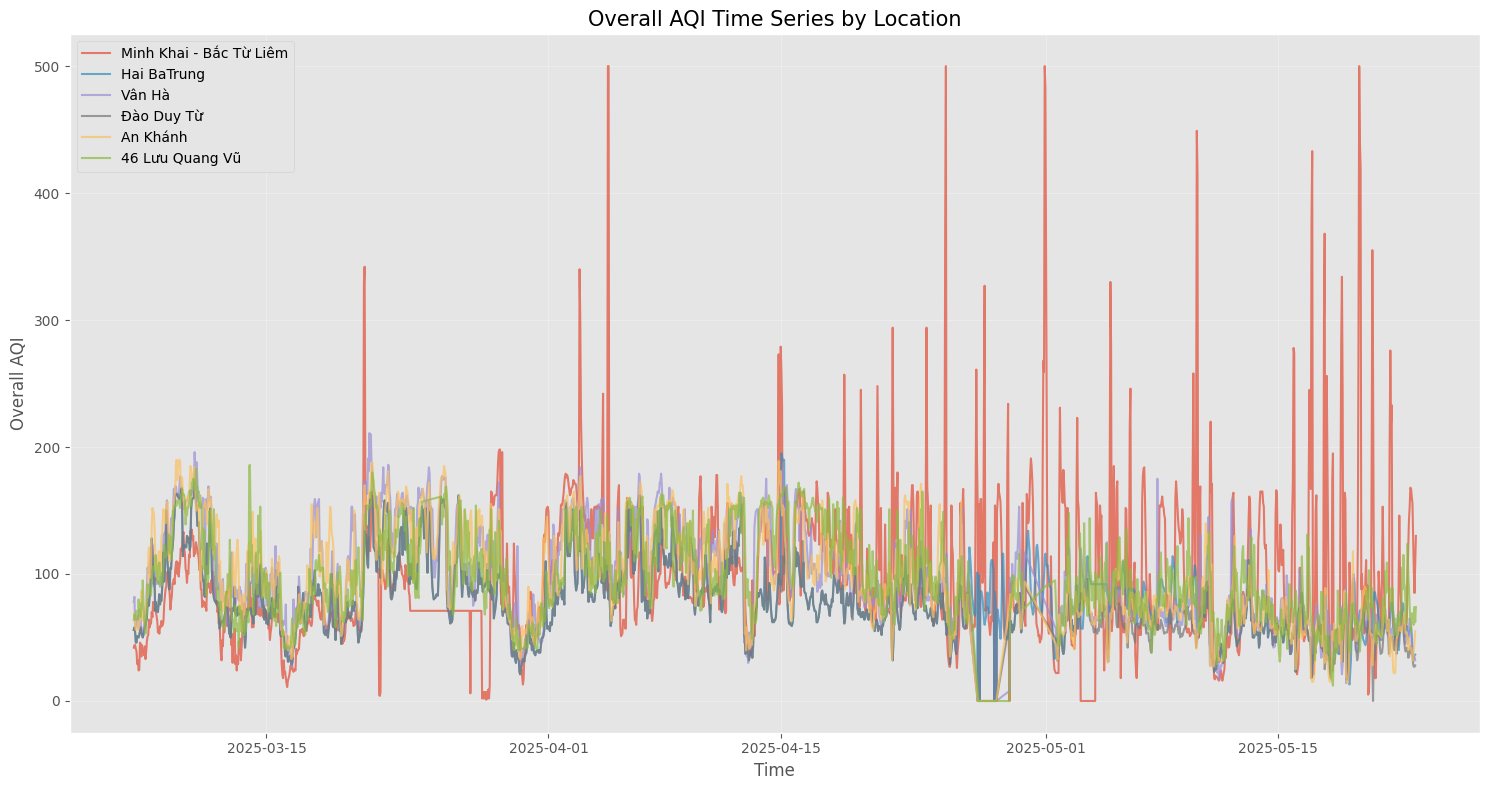

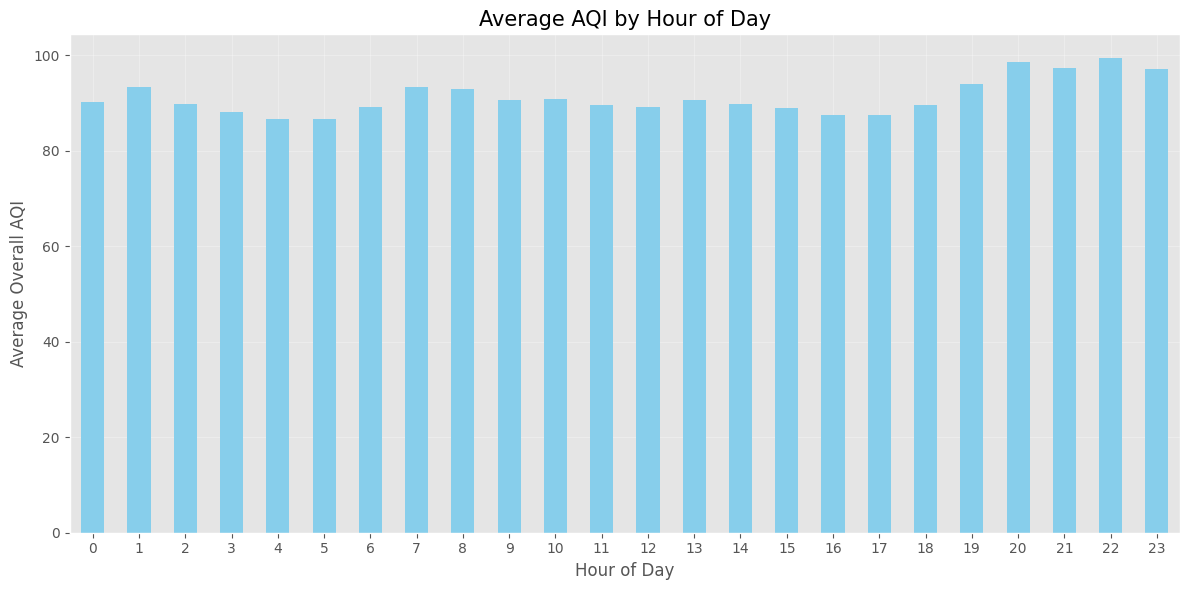

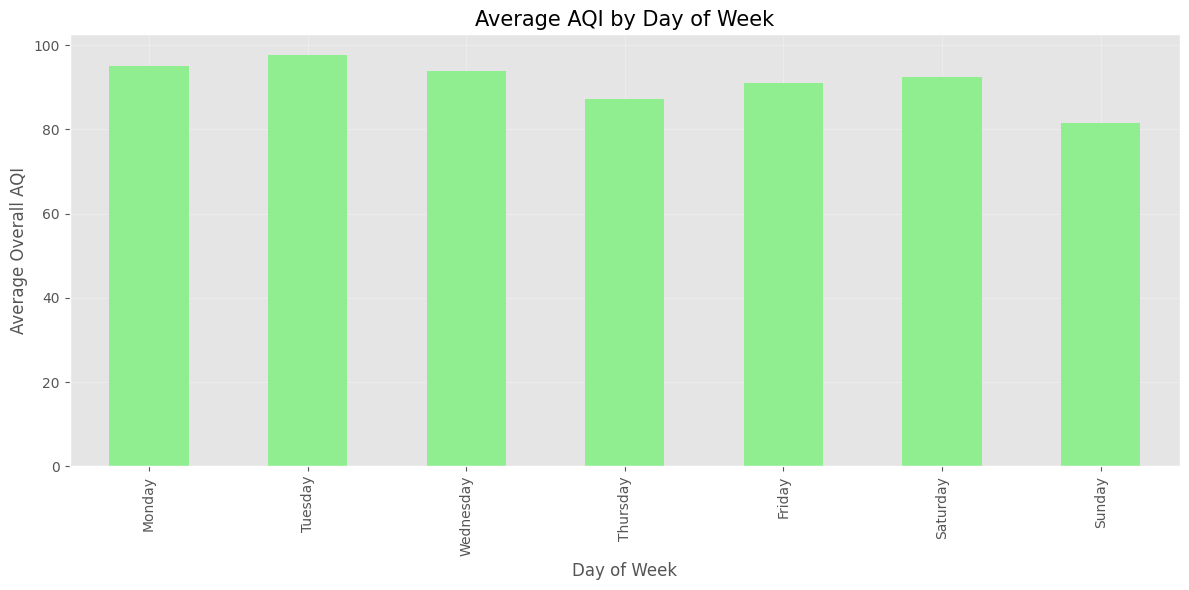

In [51]:
# Visualize AQI time series by location
plt.figure(figsize=(15, 8))

# Get top 5 locations with most data points
top_locations = historical_data['location'].value_counts().head(6).index.tolist()

for location in top_locations:
    location_data = historical_data[historical_data['location'] == location]
    plt.plot(location_data['time'], location_data['overall_aqi'], label=location, alpha=0.7)

plt.title('Overall AQI Time Series by Location', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Overall AQI', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Daily and hourly patterns
# Create time-based features
historical_data['hour'] = historical_data['time'].dt.hour
historical_data['day_of_week'] = historical_data['time'].dt.dayofweek
historical_data['month'] = historical_data['time'].dt.month

# Hourly patterns
plt.figure(figsize=(12, 6))
hourly_aqi = historical_data.groupby('hour')['overall_aqi'].mean()
hourly_aqi.plot(kind='bar', color='skyblue')
plt.title('Average AQI by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Overall AQI', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Day of week patterns
plt.figure(figsize=(12, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_aqi = historical_data.groupby('day_of_week')['overall_aqi'].mean()
daily_aqi.index = day_names
daily_aqi.plot(kind='bar', color='lightgreen')
plt.title('Average AQI by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Overall AQI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

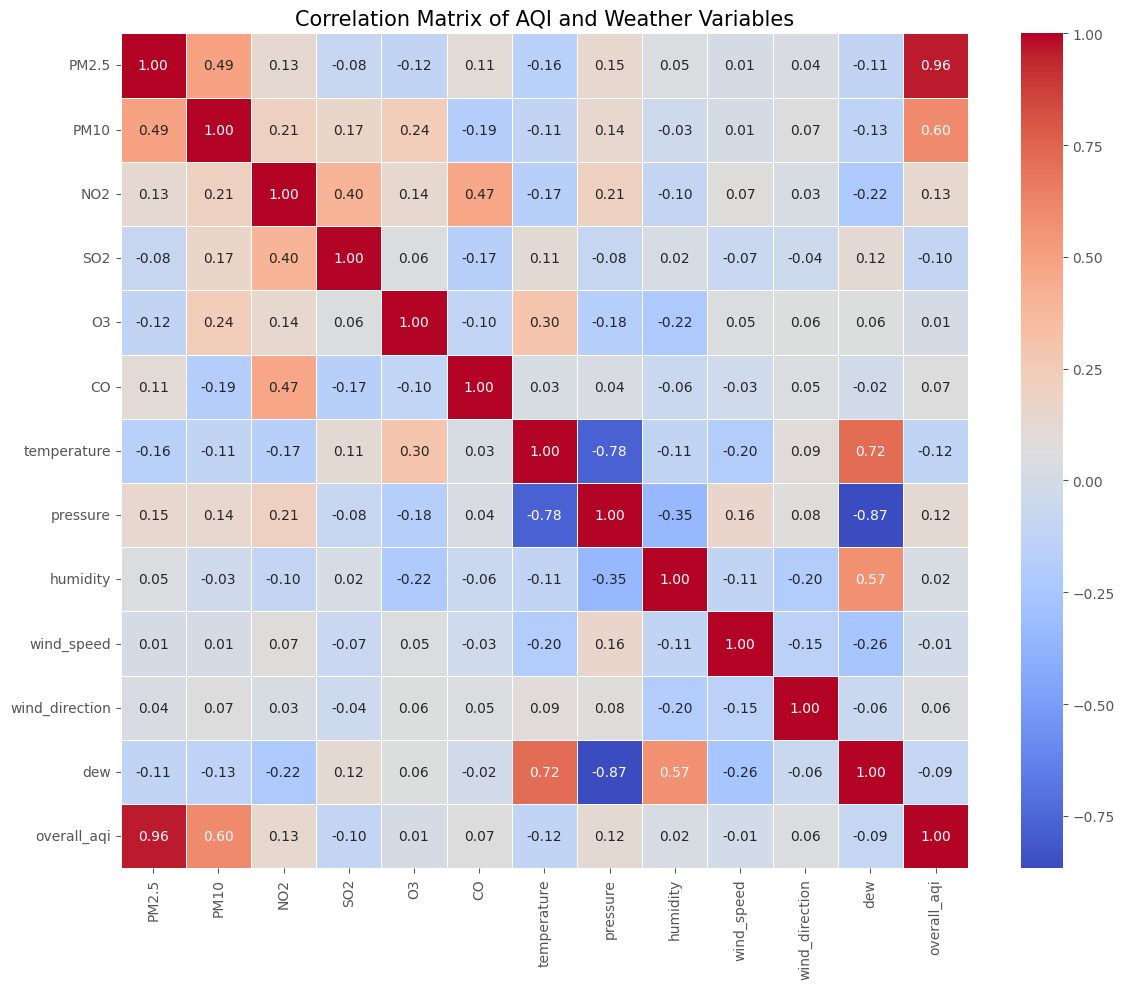

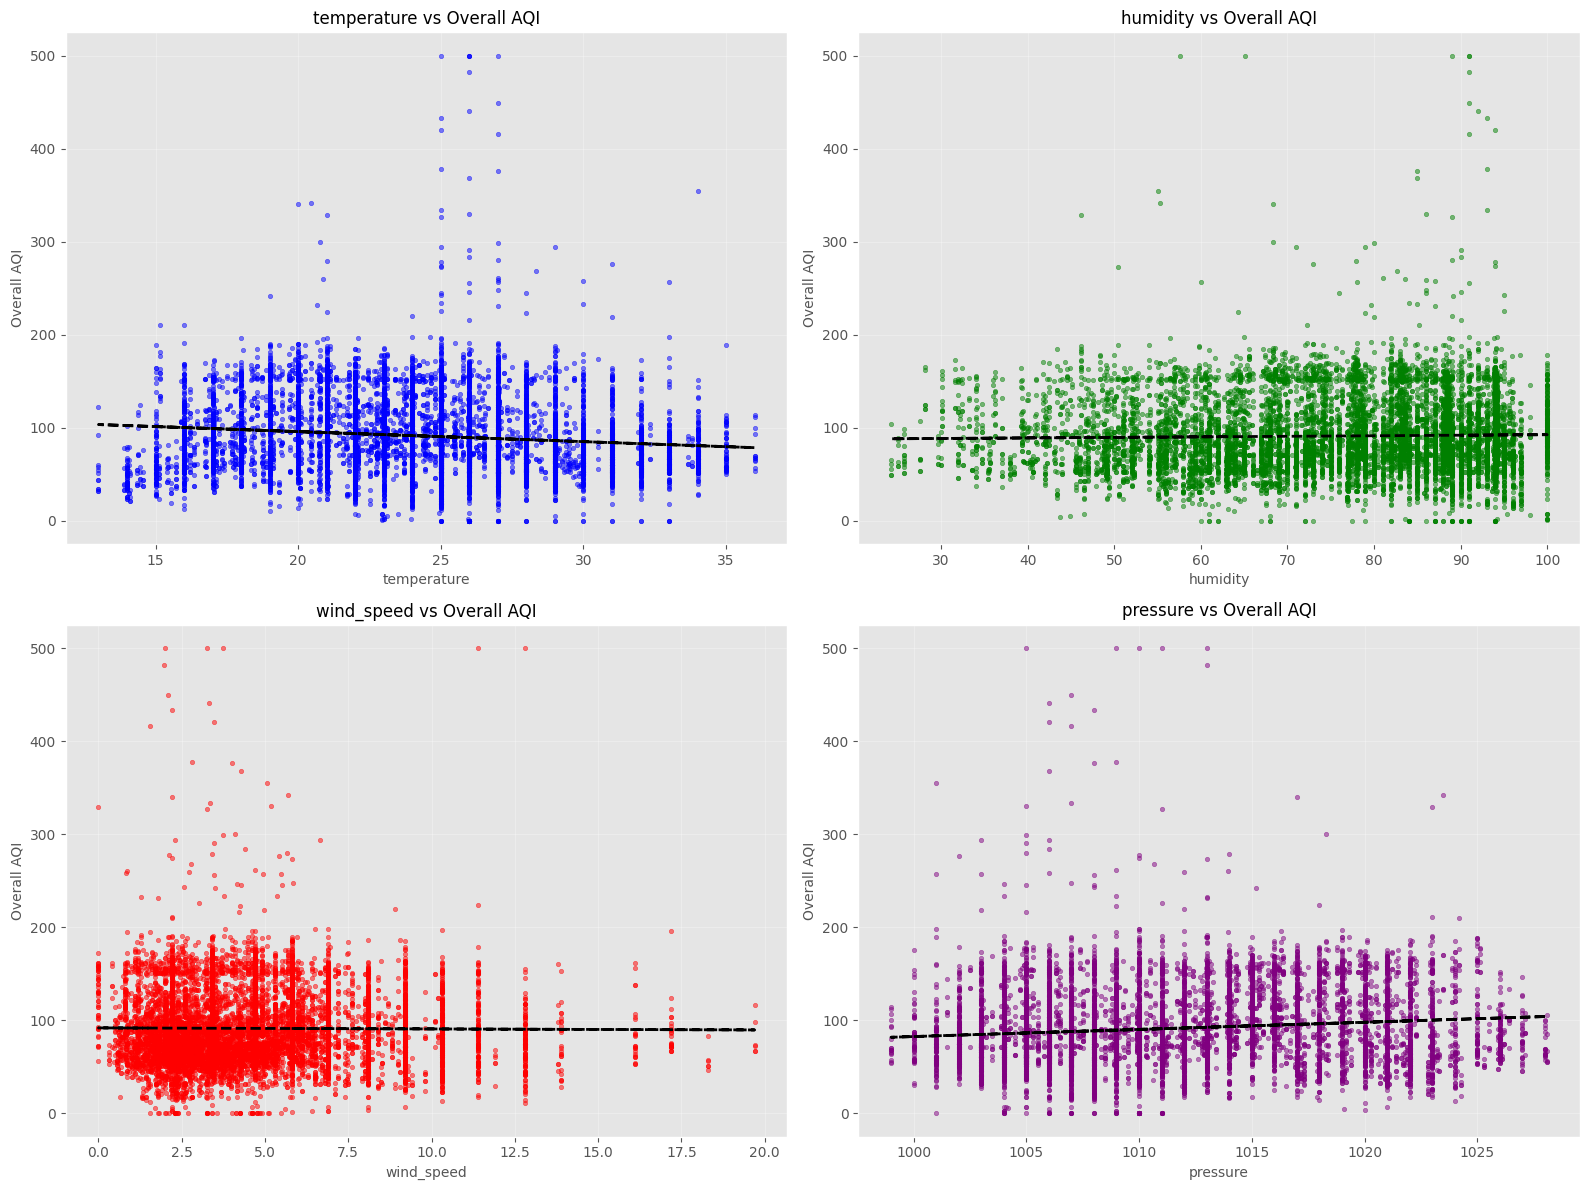

In [7]:
# Correlation analysis
# Select numeric columns for correlation
numeric_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 
                'temperature', 'pressure', 'humidity', 
                'wind_speed', 'wind_direction', 'dew', 'overall_aqi']

# Compute correlation matrix
corr_matrix = historical_data[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of AQI and Weather Variables', fontsize=15)
plt.tight_layout()
plt.show()

# Scatter plots for key relationships
plt.figure(figsize=(16, 12))

# Variables to compare with AQI
vars_to_plot = ['temperature', 'humidity', 'wind_speed', 'pressure']
colors = ['blue', 'green', 'red', 'purple']

for i, var in enumerate(vars_to_plot):
    plt.subplot(2, 2, i+1)
    plt.scatter(historical_data[var], historical_data['overall_aqi'], 
                alpha=0.5, color=colors[i], s=10)
    plt.title(f'{var} vs Overall AQI', fontsize=12)
    plt.xlabel(var, fontsize=10)
    plt.ylabel('Overall AQI', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add regression line
    if historical_data[var].notna().sum() > 0:
        m, b = np.polyfit(historical_data[var].dropna(), 
                        historical_data.loc[historical_data[var].notna(), 'overall_aqi'], 1)
        plt.plot(historical_data[var].dropna(), m*historical_data[var].dropna() + b, 'k--', lw=2)

plt.tight_layout()
plt.show()

Performing time series decomposition for location: 46 Lưu Quang Vũ


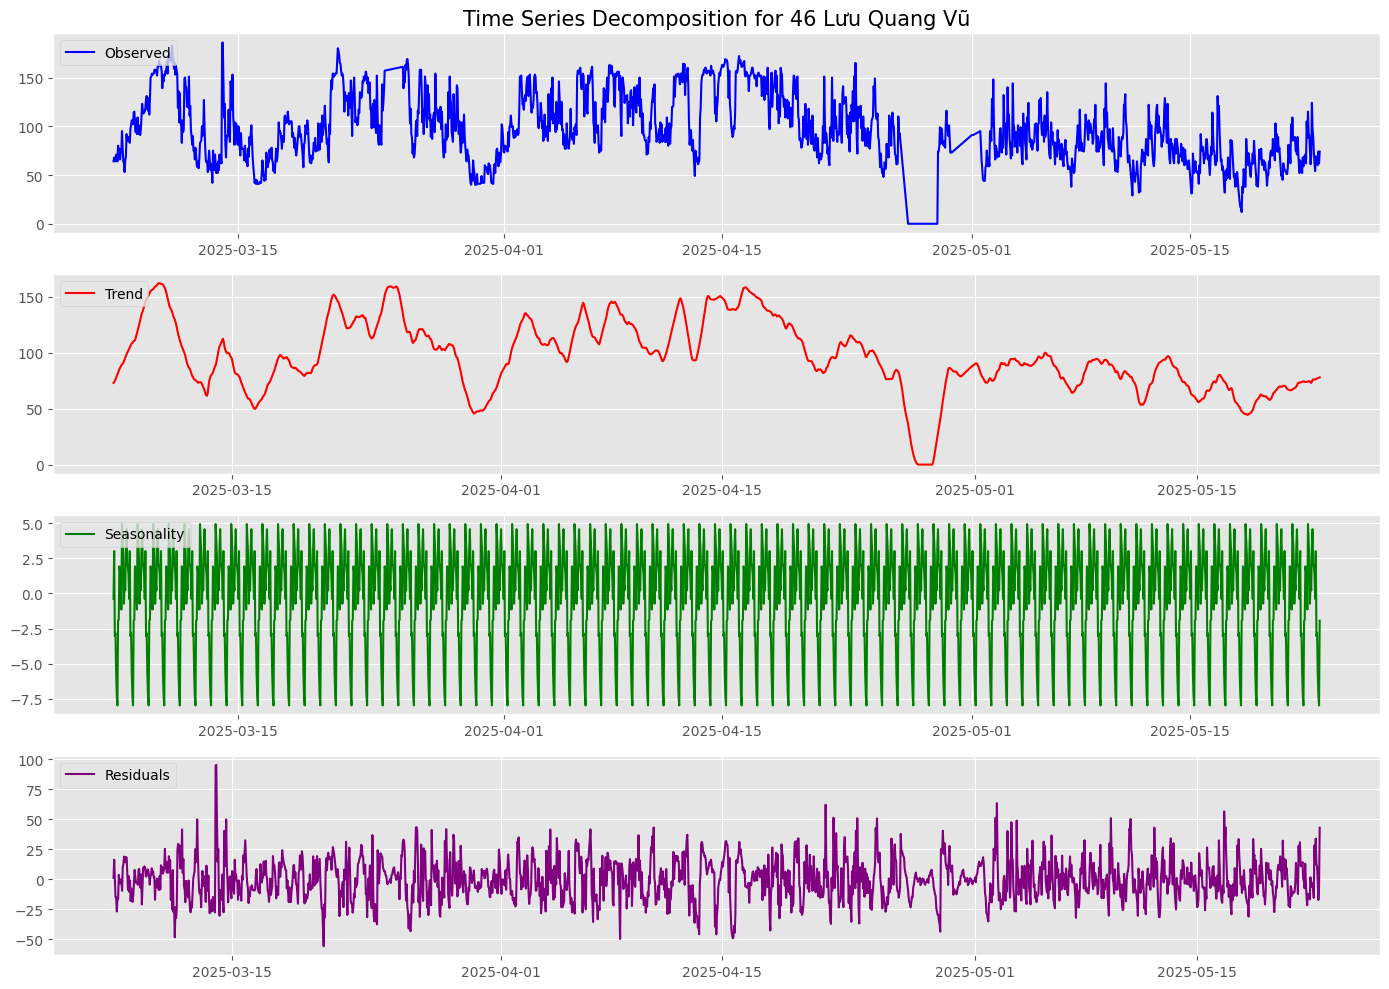

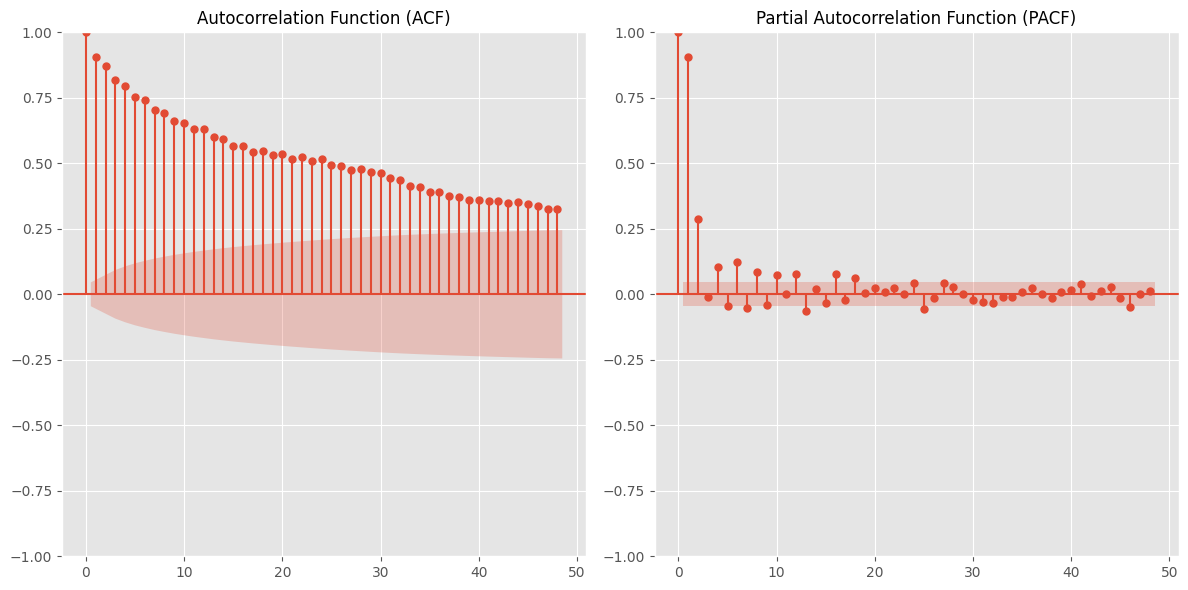

In [8]:
# Time series decomposition for a specific location
# Let's choose a location with complete data
target_location = historical_data['location'].value_counts().index[5]
print(f"Performing time series decomposition for location: {target_location}")

# Filter to one location and set time as index
location_data = historical_data[historical_data['location'] == target_location].copy()
location_data = location_data.set_index('time').sort_index()

# Resample to hourly frequency (in case there are missing values)
hourly_data = location_data['overall_aqi'].resample('H').mean()

# Fill any missing values with interpolation for decomposition
hourly_data = hourly_data.interpolate(method='time')

# Decompose the time series
try:
    # Seasonal decomposition
    decomposition = seasonal_decompose(hourly_data, model='additive', period=24)
    
    # Plot the decomposition
    plt.figure(figsize=(14, 10))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed', color='blue')
    plt.legend(loc='upper left')
    plt.title(f'Time Series Decomposition for {target_location}', fontsize=15)
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='red')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality', color='green')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='purple')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(hourly_data.dropna(), lags=48, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)', fontsize=12)
    
    plt.subplot(122)
    plot_pacf(hourly_data.dropna(), lags=48, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in time series decomposition: {e}")
    print("Make sure you have enough data points and no gaps in your time series.")

## 4. Data Preprocessing

We'll prepare the data for modeling by handling missing values, encoding categorical features, and creating a proper time series dataset.

In [44]:
# Focus on a specific location for initial modeling
# Choose the location with the most data points
target_location = historical_data['location'].value_counts().index[3]
print(f"Selected target location for modeling: {target_location}")

# Filter data for the target location
location_data = historical_data[historical_data['location'] == target_location].copy().reset_index(drop=True)

# Sort by time to ensure chronological order
location_data = location_data.sort_values('time').reset_index(drop=True)

# Display basic info about the selected location's data
print(f"Number of records for {target_location}: {len(location_data)}")
print(f"Date range: {location_data['time'].min()} to {location_data['time'].max()}")
print(f"Overall AQI range: {location_data['overall_aqi'].min()} - {location_data['overall_aqi'].max()}")

# Check for missing values in the location dataset
missing_values = location_data.isna().sum()
missing_percentage = (missing_values / len(location_data)) * 100

# Create a DataFrame for better visualization
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Display missing values for the location dataset
display(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

Selected target location for modeling: Đào Duy Từ
Number of records for Đào Duy Từ: 1756
Date range: 2025-03-07 00:00:00 to 2025-05-23 06:00:00
Overall AQI range: 0.0 - 175.0


,Missing Values,Percentage
SO2,1162,66.173121
O3,1162,66.173121
PM2.5,5,0.284738


Filled missing values in PM2.5
Filled missing values in SO2
Filled missing values in O3
Remaining missing values after preprocessing: 0
Missing values in overall_aqi: 0
=== Outlier Detection and Handling ===
Detected and handled 83 outliers (4.73%) in PM2.5
  Range before: [17.00 - 175.00]
  Range after:  [17.00 - 142.62]
Detected and handled 16 outliers (0.91%) in PM10
  Range before: [0.00 - 100.00]
  Range after:  [0.00 - 74.38]
Detected and handled 58 outliers (3.30%) in NO2
  Range before: [0.00 - 86.00]
  Range after:  [0.50 - 52.50]
Detected and handled 35 outliers (1.99%) in CO
  Range before: [0.00 - 39.00]
  Range after:  [0.00 - 20.00]
Detected and handled 6 outliers (0.34%) in humidity
  Range before: [24.22 - 100.00]
  Range after:  [28.83 - 100.00]
Detected and handled 58 outliers (3.30%) in wind_speed
  Range before: [0.00 - 19.70]
  Range after:  [0.00 - 11.33]
Detected and handled 339 outliers (19.31%) in wind_direction
  Range before: [0.00 - 360.00]
  Range after:  [

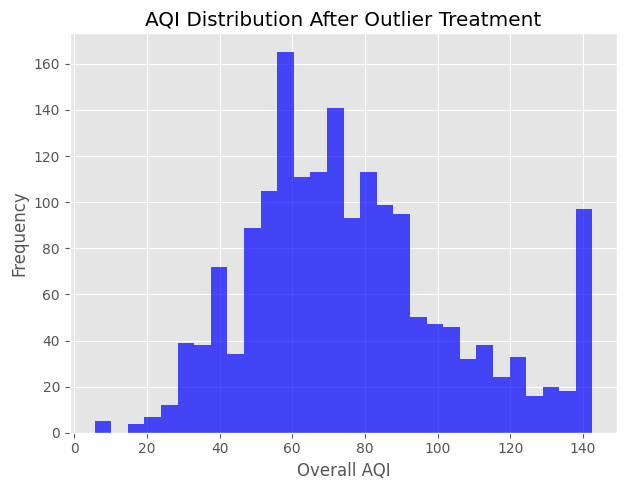

In [45]:
# Handle missing values
# For numerical columns, use interpolation
numeric_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 
                'temperature', 'pressure', 'humidity', 
                'wind_speed', 'wind_direction', 'dew', 'overall_aqi']

# First, ensure 'time' is a datetime
location_data['time'] = pd.to_datetime(location_data['time'])

# Set time as index for interpolation
location_data_indexed = location_data.set_index('time')

# Interpolate numeric columns
for col in numeric_cols:
    if location_data_indexed[col].isna().any():
        # Linear interpolation for missing values
        location_data_indexed[col] = location_data_indexed[col].interpolate(method='time')
        
        # Forward/backward fill any remaining NAs at edges
        location_data_indexed[col] = location_data_indexed[col].fillna(method='ffill').fillna(method='bfill')
        
        print(f"Filled missing values in {col}")

# Handle weather_icon (categorical)
if 'weather_icon' in location_data_indexed.columns and location_data_indexed['weather_icon'].isna().any():
    # Fill with mode (most common value)
    most_common = location_data_indexed['weather_icon'].mode()[0]
    location_data_indexed['weather_icon'] = location_data_indexed['weather_icon'].fillna(most_common)
    print(f"Filled missing weather_icon values with most common: {most_common}")

# Reset index to get time as a column again
location_data = location_data_indexed.reset_index()

# Check if we've successfully handled all missing values
remaining_missing = location_data.isna().sum().sum()
print(f"Remaining missing values after preprocessing: {remaining_missing}")

# Verify data is complete for the overall_aqi (our target variable)
print(f"Missing values in overall_aqi: {location_data['overall_aqi'].isna().sum()}")

# Add robust outlier detection and handling
print("=== Outlier Detection and Handling ===")
numerical_features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 
                      'temperature', 'pressure', 'humidity', 
                      'wind_speed', 'wind_direction', 'dew', 'overall_aqi']

# Function to detect and handle outliers using IQR method
def handle_outliers_iqr(df, column, lower_factor=1.5, upper_factor=1.5):
    """
    Detect and handle outliers using the Interquartile Range (IQR) method
    
    Args:
        df: DataFrame containing the data
        column: Column name to check for outliers
        lower_factor: Factor to multiply IQR for lower bound (default 1.5)
        upper_factor: Factor to multiply IQR for upper bound (default 1.5)
        
    Returns:
        Tuple containing (outlier_indices, outlier_values)
    """
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - (lower_factor * IQR)
    upper_bound = Q3 + (upper_factor * IQR)
    
    # Find outliers
    outlier_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    outlier_values = df.loc[outlier_indices, column].values
    
    # Winsorize (cap) outliers instead of removing them
    if len(outlier_indices) > 0:
        # Cap upper outliers
        df.loc[df[column] > upper_bound, column] = upper_bound
        # Cap lower outliers (only if they're not negative by nature)
        if lower_bound >= 0 or column not in ['temperature', 'wind_direction', 'pressure']:
            df.loc[df[column] < lower_bound, column] = lower_bound
        
    return outlier_indices, outlier_values

# Apply outlier detection and handling to each numerical feature
outlier_summary = {}
for col in numerical_features:
    if col in location_data.columns:
        before_outliers = location_data[col].describe()
        outlier_indices, outlier_values = handle_outliers_iqr(location_data, col)
        after_outliers = location_data[col].describe()
        
        outlier_summary[col] = {
            'num_outliers': len(outlier_indices),
            'percentage': (len(outlier_indices) / len(location_data)) * 100,
            'max_before': before_outliers['max'],
            'max_after': after_outliers['max'],
            'min_before': before_outliers['min'],
            'min_after': after_outliers['min']
        }
        
        if len(outlier_indices) > 0:
            print(f"Detected and handled {len(outlier_indices)} outliers ({outlier_summary[col]['percentage']:.2f}%) in {col}")
            print(f"  Range before: [{outlier_summary[col]['min_before']:.2f} - {outlier_summary[col]['max_before']:.2f}]")
            print(f"  Range after:  [{outlier_summary[col]['min_after']:.2f} - {outlier_summary[col]['max_after']:.2f}]")

# Create separate strategies for extreme pollution events
extreme_pollution = location_data['overall_aqi'] > 250
if extreme_pollution.sum() > 0:
    print(f"\nIdentified {extreme_pollution.sum()} extreme pollution events (AQI > 250)")
    location_data['is_extreme_event'] = extreme_pollution.astype(int)
else:
    location_data['is_extreme_event'] = 0
    print("\nNo extreme pollution events detected in this dataset")

# Display histograms before and after outlier treatment for the target variable
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(location_data['overall_aqi'], bins=30, alpha=0.7, color='blue')
plt.title('AQI Distribution After Outlier Treatment')
plt.xlabel('Overall AQI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [46]:
# Encode categorical variables
# For weather_icon, we'll use one-hot encoding
if 'weather_icon' in location_data.columns:
    # Extract first 2 characters (main weather condition code)
    location_data['weather_condition'] = location_data['weather_icon'].str[:2]
    
    # One-hot encode the weather condition
    weather_dummies = pd.get_dummies(location_data['weather_condition'], prefix='weather')
    
    # Concatenate with the original dataframe
    location_data = pd.concat([location_data, weather_dummies], axis=1)
    
    print(f"Created {len(weather_dummies.columns)} weather condition dummy variables")

# Extract time-based features
location_data['hour'] = location_data['time'].dt.hour
location_data['day_of_week'] = location_data['time'].dt.dayofweek
location_data['month'] = location_data['time'].dt.month
location_data['day_of_year'] = location_data['time'].dt.dayofyear
location_data['is_weekend'] = location_data['day_of_week'].isin([5, 6]).astype(int)

# Create cyclical features for time variables
# This preserves the cyclical nature of time features
location_data['hour_sin'] = np.sin(2 * np.pi * location_data['hour']/24)
location_data['hour_cos'] = np.cos(2 * np.pi * location_data['hour']/24)
location_data['month_sin'] = np.sin(2 * np.pi * location_data['month']/12)
location_data['month_cos'] = np.cos(2 * np.pi * location_data['month']/12)
location_data['day_of_week_sin'] = np.sin(2 * np.pi * location_data['day_of_week']/7)
location_data['day_of_week_cos'] = np.cos(2 * np.pi * location_data['day_of_week']/7)
location_data['wind_direction_sin'] = np.sin(2 * np.pi * location_data['wind_direction']/360)
location_data['wind_direction_cos'] = np.cos(2 * np.pi * location_data['wind_direction']/360)

print("Created cyclical time-based features")

# Display the final preprocessed dataset
print(f"Final dataset shape: {location_data.shape}")
display(location_data.head())

Created 6 weather condition dummy variables
Created cyclical time-based features
Final dataset shape: (1756, 37)


,time,location,PM2.5,PM10,NO2,SO2,O3,CO,temperature,pressure,...,day_of_year,is_weekend,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,wind_direction_sin,wind_direction_cos
0,2025-03-07 00:00:00,Đào Duy Từ,56.0,17.0,27.0,0.0,9.0,4.0,15.000000,1022.0,...,66,0,0.000000,1.000000,1.0,6.123234e-17,-0.433884,-0.900969,0.939693,0.342020
1,2025-03-07 01:00:00,Đào Duy Từ,58.0,19.0,25.0,0.0,9.0,4.0,15.444444,1021.9,...,66,0,0.258819,0.965926,1.0,6.123234e-17,-0.433884,-0.900969,0.838671,0.544639
2,2025-03-07 02:00:00,Đào Duy Từ,54.0,16.0,21.0,0.0,9.0,3.0,16.000000,1022.0,...,66,0,0.500000,0.866025,1.0,6.123234e-17,-0.433884,-0.900969,0.642788,0.766044
3,2025-03-07 03:00:00,Đào Duy Từ,46.0,13.0,20.0,0.0,9.0,3.0,15.000000,1022.0,...,66,0,0.707107,0.707107,1.0,6.123234e-17,-0.433884,-0.900969,0.866025,0.500000
4,2025-03-07 04:00:00,Đào Duy Từ,46.0,13.0,21.0,0.0,9.0,3.0,15.111111,1021.4,...,66,0,0.866025,0.500000,1.0,6.123234e-17,-0.433884,-0.900969,0.809017,0.587785


## 5. Feature Engineering for Time Series Forecasting

We'll create lagged features and rolling window statistics to capture temporal patterns in the data. This is crucial for forecasting future values.

In [47]:
# Create a function to generate features for time series forecasting
def create_time_series_features(df, target_col='overall_aqi', lag_hours=[1, 2, 3, 6, 12, 24], 
                              rolling_windows=[3, 6, 12, 24]):
    """
    Create time series features including:
    - Lagged values (previous hours)
    - Rolling statistics (mean, std, min, max)
    - Time-based features (already created in preprocessing)
    
    Args:
        df: DataFrame with time series data (sorted by time)
        target_col: Column to create features for
        lag_hours: List of lag periods (in hours) to create
        rolling_windows: List of rolling window sizes for statistics
        
    Returns:
        DataFrame with additional features
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Make sure data is sorted by time
    result_df = result_df.sort_values('time').reset_index(drop=True)
    
    # Create lagged features
    for lag in lag_hours:
        result_df[f'{target_col}_lag_{lag}h'] = result_df[target_col].shift(lag)
        print(f"Created {target_col}_lag_{lag}h feature")
    
    # Create rolling window statistics
    for window in rolling_windows:
        # Rolling mean
        result_df[f'{target_col}_rolling_mean_{window}h'] = result_df[target_col].rolling(window=window).mean().shift(1)
        
        # Rolling standard deviation
        result_df[f'{target_col}_rolling_std_{window}h'] = result_df[target_col].rolling(window=window).std().shift(1)
        
        # Rolling min and max
        result_df[f'{target_col}_rolling_min_{window}h'] = result_df[target_col].rolling(window=window).min().shift(1)
        result_df[f'{target_col}_rolling_max_{window}h'] = result_df[target_col].rolling(window=window).max().shift(1)
        
        print(f"Created rolling statistics with {window}h window")
    
    # Create lag differences (rate of change)
    for lag in lag_hours:
        if lag > 1:  # Skip lag 1 as it would be the same as regular lag
            result_df[f'{target_col}_diff_{lag}h'] = result_df[target_col] - result_df[f'{target_col}_lag_{lag}h']
            print(f"Created difference feature: {target_col}_diff_{lag}h")
    
    # Create lagged features for weather variables
    weather_vars = ['temperature', 'humidity', 'pressure', 'wind_speed']
    for var in weather_vars:
        if var in result_df.columns:
            # 1-hour and 24-hour lags for weather variables
            result_df[f'{var}_lag_1h'] = result_df[var].shift(1)
            result_df[f'{var}_lag_24h'] = result_df[var].shift(24)
            print(f"Created lagged features for {var}")
    
    # Add day/night indicator (6am-6pm is day, else night)
    result_df['is_daytime'] = ((result_df['hour'] >= 6) & (result_df['hour'] < 18)).astype(int)
    print("Added day/night indicator")
    
    return result_df

# Apply the feature engineering function
ts_features_df = create_time_series_features(location_data)

# Display the resulting dataset shape
print(f"Original dataset shape: {location_data.shape}")
print(f"Feature-engineered dataset shape: {ts_features_df.shape}")
print(f"Added {ts_features_df.shape[1] - location_data.shape[1]} new features")

# Display the first few rows of the feature-engineered dataset
display(ts_features_df.head())

# Check for missing values created by lag/rolling operations
missing_after_features = ts_features_df.isna().sum()
print(f"Columns with missing values after feature engineering: {sum(missing_after_features > 0)}")

Created overall_aqi_lag_1h feature
Created overall_aqi_lag_2h feature
Created overall_aqi_lag_3h feature
Created overall_aqi_lag_6h feature
Created overall_aqi_lag_12h feature
Created overall_aqi_lag_24h feature
Created rolling statistics with 3h window
Created rolling statistics with 6h window
Created rolling statistics with 12h window
Created rolling statistics with 24h window
Created difference feature: overall_aqi_diff_2h
Created difference feature: overall_aqi_diff_3h
Created difference feature: overall_aqi_diff_6h
Created difference feature: overall_aqi_diff_12h
Created difference feature: overall_aqi_diff_24h
Created lagged features for temperature
Created lagged features for humidity
Created lagged features for pressure
Created lagged features for wind_speed
Added day/night indicator
Original dataset shape: (1756, 37)
Feature-engineered dataset shape: (1756, 73)
Added 36 new features


,time,location,PM2.5,PM10,NO2,SO2,O3,CO,temperature,pressure,...,overall_aqi_diff_24h,temperature_lag_1h,temperature_lag_24h,humidity_lag_1h,humidity_lag_24h,pressure_lag_1h,pressure_lag_24h,wind_speed_lag_1h,wind_speed_lag_24h,is_daytime
0,2025-03-07 00:00:00,Đào Duy Từ,56.0,17.0,27.0,0.0,9.0,4.0,15.000000,1022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2025-03-07 01:00:00,Đào Duy Từ,58.0,19.0,25.0,0.0,9.0,4.0,15.444444,1021.9,...,NaN,15.000000,NaN,62.95,NaN,1022.0,NaN,5.8,NaN,0
2,2025-03-07 02:00:00,Đào Duy Từ,54.0,16.0,21.0,0.0,9.0,3.0,16.000000,1022.0,...,NaN,15.444444,NaN,60.61,NaN,1021.9,NaN,6.8,NaN,0
3,2025-03-07 03:00:00,Đào Duy Từ,46.0,13.0,20.0,0.0,9.0,3.0,15.000000,1022.0,...,NaN,16.000000,NaN,55.14,NaN,1022.0,NaN,6.9,NaN,0
4,2025-03-07 04:00:00,Đào Duy Từ,46.0,13.0,21.0,0.0,9.0,3.0,15.111111,1021.4,...,NaN,15.000000,NaN,58.79,NaN,1022.0,NaN,8.1,NaN,0


Columns with missing values after feature engineering: 35


In [48]:
# Prepare the dataset for supervised learning
# We need to handle the NaN values created by lagging operations
# and split into training and validation sets respecting time order

# First, drop rows with NaN values (these will be the first rows with lagged features)
max_lag = 24  # Our maximum lag is 24 hours
ts_features_clean = ts_features_df.iloc[max_lag:].copy()

# Check if we still have any NaN values
remaining_nans = ts_features_clean.isna().sum().sum()
print(f"Remaining NaN values after dropping initial rows: {remaining_nans}")

# If we still have NaN values, handle them
if remaining_nans > 0:
    # Identify columns with NaN values
    cols_with_nans = ts_features_clean.columns[ts_features_clean.isna().any()].tolist()
    print(f"Columns with remaining NaN values: {cols_with_nans}")
    
    # For each column with NaNs, fill with appropriate method
    for col in cols_with_nans:
        # For rolling statistics, forward fill
        if 'rolling' in col:
            ts_features_clean[col] = ts_features_clean[col].fillna(method='ffill')
        # For lag differences, use 0 (no change)
        elif 'diff' in col:
            ts_features_clean[col] = ts_features_clean[col].fillna(0)
        # For other features, use column mean
        else:
            ts_features_clean[col] = ts_features_clean[col].fillna(ts_features_clean[col].mean())

# Define features and target
target_col = 'overall_aqi'

# Features to exclude from the model
exclude_cols = ['time', 'location', 'weather_icon', 'weather_condition']

# Define features: all columns except target and excluded columns
features = [col for col in ts_features_clean.columns 
            if col != target_col and col not in exclude_cols]

print(f"Number of features for modeling: {len(features)}")

# Split into training and validation sets (2/3 for training, 1/3 for validation)
# We need to respect the time ordering
train_size = int(len(ts_features_clean) * 2 / 3)
train_df = ts_features_clean.iloc[:train_size]
val_df = ts_features_clean.iloc[train_size:]

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Training period: {train_df['time'].min()} to {train_df['time'].max()}")
print(f"Validation period: {val_df['time'].min()} to {val_df['time'].max()}")

# Create X and y for both sets
X_train = train_df[features]
y_train = train_df[target_col]
X_val = val_df[features]
y_val = val_df[target_col]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled successfully")

Remaining NaN values after dropping initial rows: 0
Number of features for modeling: 68
Training set size: 1154
Validation set size: 578
Training period: 2025-03-08 00:00:00 to 2025-04-25 01:00:00
Validation period: 2025-04-25 02:00:00 to 2025-05-23 06:00:00
Features scaled successfully


## 6. Model Building

We'll train multiple models to forecast AQI values and compare their performance. The models include XGBoost, Random Forest, and GradientBoost for time series forecasting.

Training XGBoost model...
XGBoost - MAE: 0.92, RMSE: 4.48, R²: 0.918
Training Random Forest model...
XGBoost - MAE: 0.92, RMSE: 4.48, R²: 0.918
Training Random Forest model...
Random Forest - MAE: 0.62, RMSE: 5.13, R²: 0.893
Training Gradient Boosting model...
Random Forest - MAE: 0.62, RMSE: 5.13, R²: 0.893
Training Gradient Boosting model...
Gradient Boosting - MAE: 0.54, RMSE: 5.09, R²: 0.895
Gradient Boosting - MAE: 0.54, RMSE: 5.09, R²: 0.895


,model,MAE,RMSE,R2
0,XGBoost,0.924927,4.480448,0.918497
1,Random Forest,0.624741,5.129212,0.893185
2,Gradient Boosting,0.537169,5.087852,0.894900


Best model: XGBoost


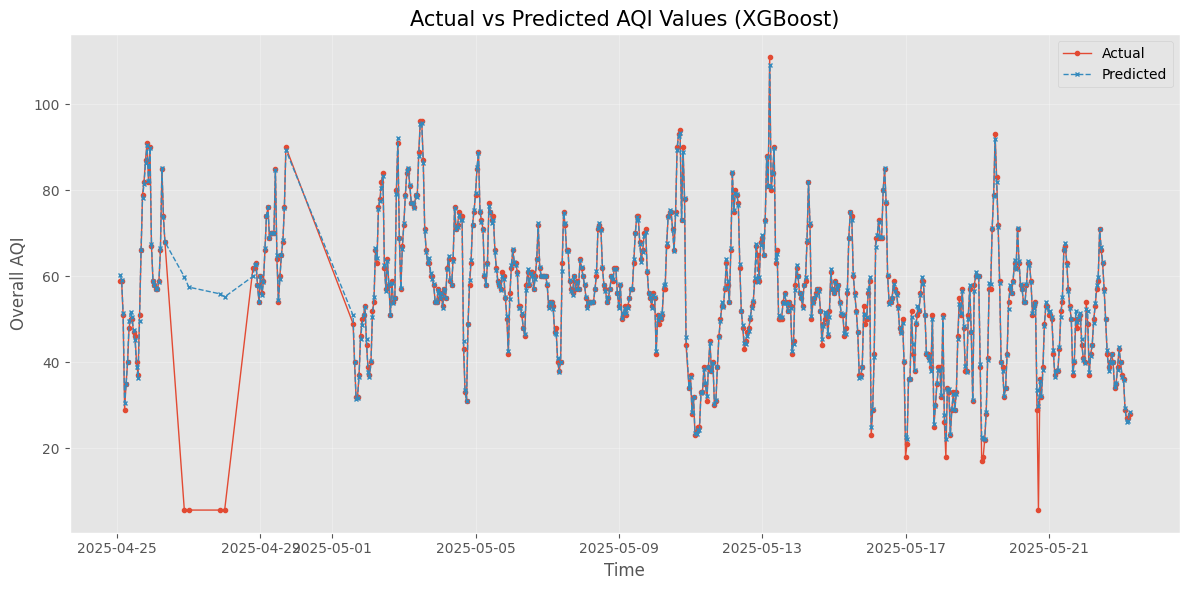

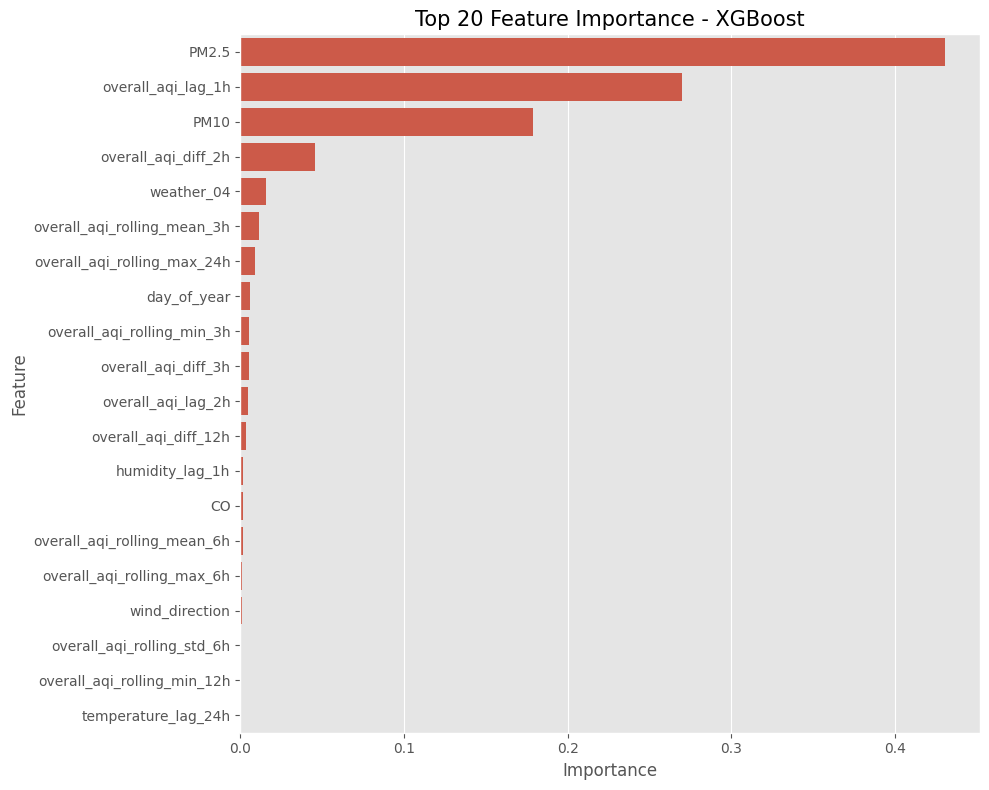

In [49]:
# Define a function to evaluate a model
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance using multiple metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Train and evaluate multiple models
models = {}
results = []

# 1. XGBoost Regressor
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.08, 
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)
models['XGBoost'] = xgb_model
results.append(evaluate_model(y_val, xgb_pred, 'XGBoost'))

# 2. Random Forest Regressor
print("Training Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)
models['Random Forest'] = rf_model
results.append(evaluate_model(y_val, rf_pred, 'Random Forest'))

# 3. Gradient Boosting Regressor
print("Training Gradient Boosting model...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_val_scaled)
models['Gradient Boosting'] = gb_model
results.append(evaluate_model(y_val, gb_pred, 'Gradient Boosting'))

# Create a DataFrame with results
results_df = pd.DataFrame(results)
display(results_df)

# Visualize actual vs predicted values for the best model
best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'model']
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Get predictions from the best model
if best_model_name == 'XGBoost':
    best_pred = xgb_pred
elif best_model_name == 'Random Forest':
    best_pred = rf_pred
else:
    best_pred = gb_pred

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(val_df['time'], y_val, label='Actual', marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(val_df['time'], best_pred, label='Predicted', marker='x', markersize=3, linestyle='--', linewidth=1)
plt.title(f'Actual vs Predicted AQI Values ({best_model_name})', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Overall AQI', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check feature importance for tree-based models
if best_model_name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
    # Get feature importance
    if best_model_name == 'XGBoost':
        importance = best_model.feature_importances_
    else:
        importance = best_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 most important features
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

Performing hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
Best cross-validation RMSE: 1.22
Tuned XGBoost - MAE: 0.56, RMSE: 5.05, R²: 0.896
Improvement: -0.57 RMSE
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
Best cross-validation RMSE: 1.22
Tuned XGBoost - MAE: 0.56, RMSE: 5.05, R²: 0.896
Improvement: -0.57 RMSE


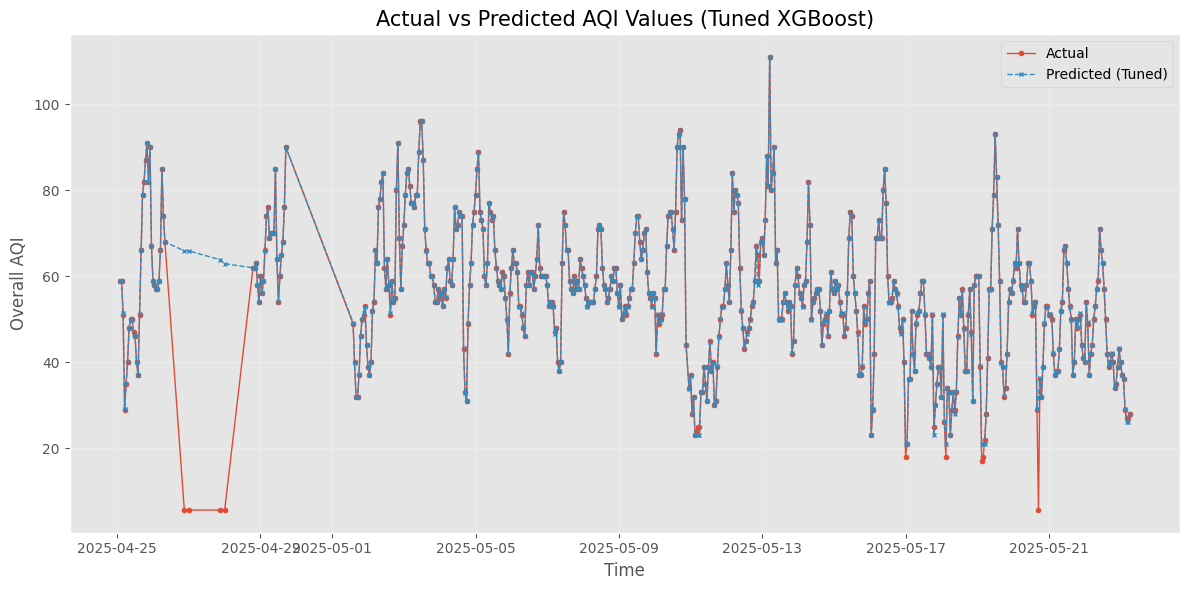

In [50]:
# Hyperparameter tuning for the best model
# We'll use TimeSeriesSplit for cross-validation to respect time order
print(f"Performing hyperparameter tuning for {best_model_name}...")

# Create time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameter grid based on the best model
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'subsample': [0.6, 0.8, 1.0]
    }
    model = xgb.XGBRegressor(random_state=42)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    
else:  # Gradient Boosting
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.6, 0.8, 1.0]
    }
    model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert back to RMSE

print(f"Best parameters: {best_params}")
print(f"Best cross-validation RMSE: {best_score:.2f}")

# Train a model with the best parameters
tuned_model = grid_search.best_estimator_
tuned_pred = tuned_model.predict(X_val_scaled)

# Evaluate the tuned model
tuned_results = evaluate_model(y_val, tuned_pred, f'Tuned {best_model_name}')

# Compare with the original model
print(f"Improvement: {results_df[results_df['model'] == best_model_name]['RMSE'].values[0] - tuned_results['RMSE']:.2f} RMSE")

# Save the best model
models['Tuned ' + best_model_name] = tuned_model

# Plot actual vs predicted for the tuned model
plt.figure(figsize=(12, 6))
plt.plot(val_df['time'], y_val, label='Actual', marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(val_df['time'], tuned_pred, label='Predicted (Tuned)', marker='x', markersize=3, linestyle='--', linewidth=1)
plt.title(f'Actual vs Predicted AQI Values (Tuned {best_model_name})', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Overall AQI', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our best model thoroughly and understand its strengths and limitations.

Error Statistics:
Mean Error: -0.36
Mean Absolute Error: 0.83
Standard Deviation of Error: 7.11
Min Error: -92.49
Max Error: 35.99


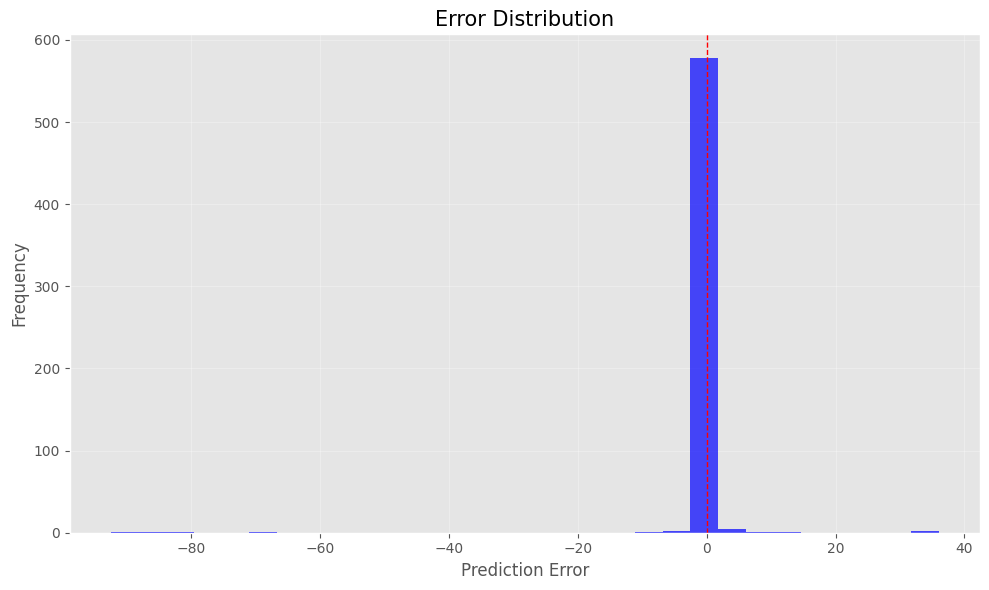

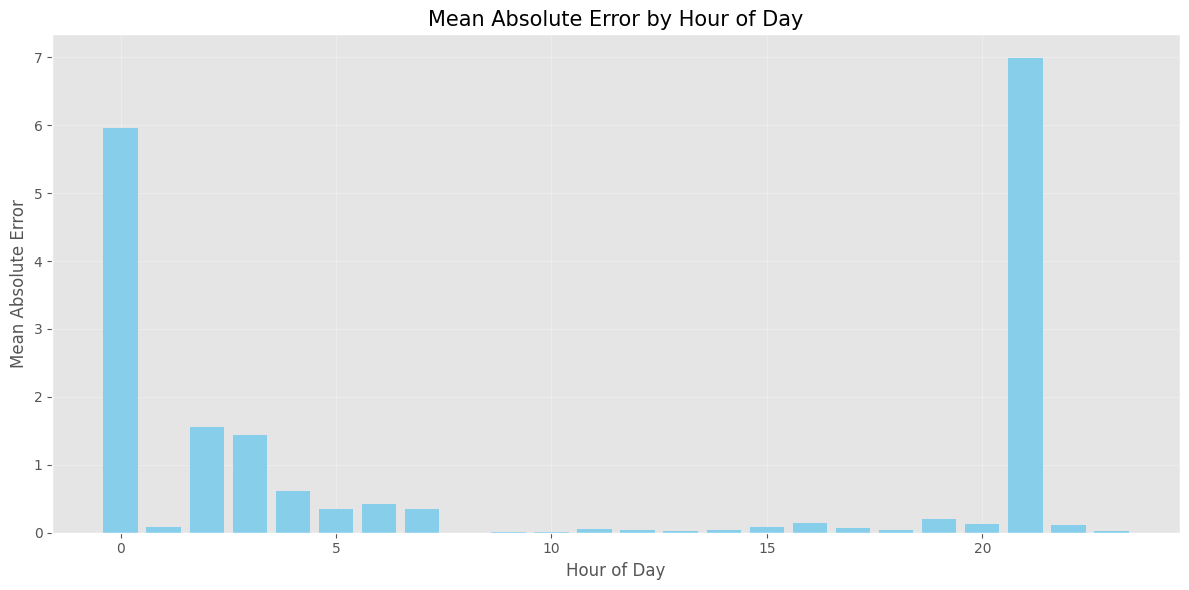

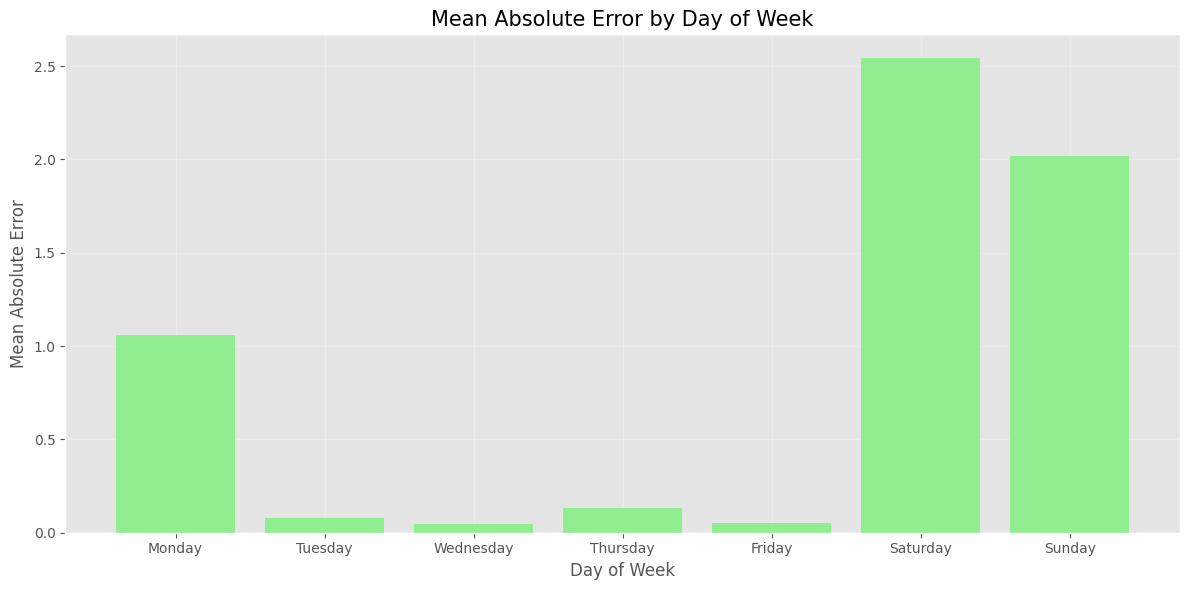

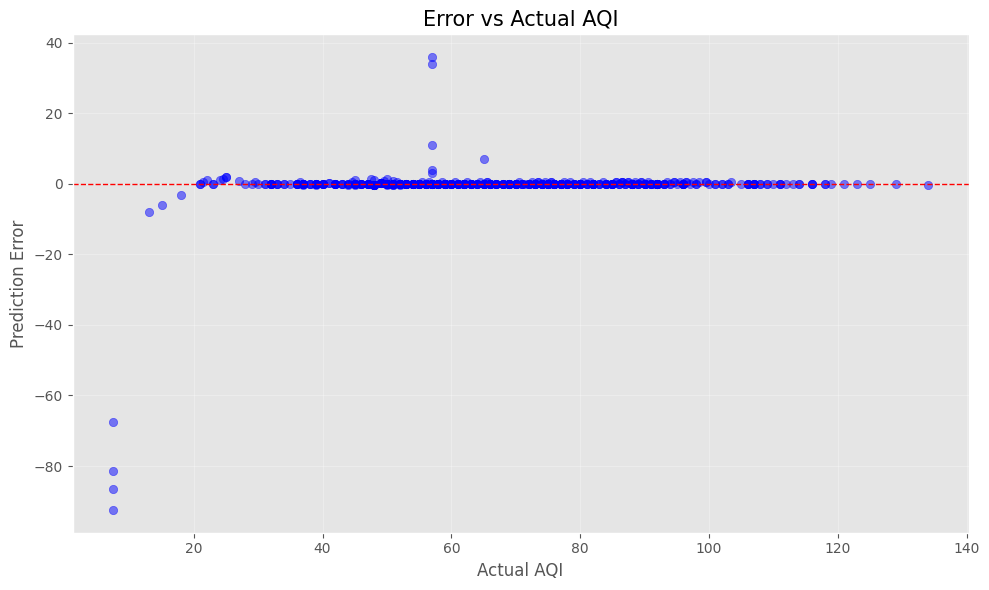

In [34]:
# Error analysis for the tuned model
final_model_name = f'Tuned {best_model_name}'
final_model = models[final_model_name]
final_pred = tuned_model.predict(X_val_scaled)

# Calculate errors
errors = y_val - final_pred
abs_errors = np.abs(errors)

# Create a DataFrame to analyze errors
error_df = pd.DataFrame({
    'Time': val_df['time'],
    'Actual': y_val,
    'Predicted': final_pred,
    'Error': errors,
    'Abs_Error': abs_errors,
    'Hour': val_df['hour'],
    'Day_of_Week': val_df['day_of_week']
})

# Display basic error statistics
print("Error Statistics:")
print(f"Mean Error: {errors.mean():.2f}")
print(f"Mean Absolute Error: {abs_errors.mean():.2f}")
print(f"Standard Deviation of Error: {errors.std():.2f}")
print(f"Min Error: {errors.min():.2f}")
print(f"Max Error: {errors.max():.2f}")

# Visualize error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Error Distribution', fontsize=15)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze errors by time patterns
# By hour of day
hourly_errors = error_df.groupby('Hour')['Abs_Error'].mean()

plt.figure(figsize=(12, 6))
plt.bar(hourly_errors.index, hourly_errors.values, color='skyblue')
plt.title('Mean Absolute Error by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# By day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_errors = error_df.groupby('Day_of_Week')['Abs_Error'].mean()
daily_errors.index = day_names

plt.figure(figsize=(12, 6))
plt.bar(daily_errors.index, daily_errors.values, color='lightgreen')
plt.title('Mean Absolute Error by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error vs Actual Value (to check for systematic bias)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, errors, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Error vs Actual AQI', fontsize=15)
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# Identify largest errors
largest_errors = error_df.sort_values('Abs_Error', ascending=False).head(10)
print("Top 10 largest prediction errors:")
display(largest_errors)

# Save the final model
final_model_info = {
    'model': final_model,
    'features': features,
    'scaler': scaler,
    'metrics': {
        'mae': mean_absolute_error(y_val, final_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, final_pred)),
        'r2': r2_score(y_val, final_pred)
    }
}

print(f"Final model saved: {final_model_name}")
print(f"Final model performance: MAE={final_model_info['metrics']['mae']:.2f}, RMSE={final_model_info['metrics']['rmse']:.2f}")

Top 10 largest prediction errors:


,Time,Actual,Predicted,Error,Abs_Error,Hour,Day_of_Week
1210,2025-04-26 21:00:00,7.5,99.988716,-92.488716,92.488716,21,5
1233,2025-04-27 21:00:00,7.5,93.988373,-86.488373,86.488373,21,6
1213,2025-04-27 00:00:00,7.5,88.986107,-81.486107,81.486107,0,6
1236,2025-04-28 00:00:00,7.5,74.973930,-67.473930,67.473930,0,0
1350,2025-05-03 02:00:00,57.0,21.009281,35.990719,35.990719,2,5
1351,2025-05-03 03:00:00,57.0,23.018663,33.981337,33.981337,3,5
1352,2025-05-03 04:00:00,57.0,46.061520,10.938480,10.938480,4,5
1711,2025-05-19 07:00:00,13.0,21.007832,-8.007832,8.007832,7,0
1564,2025-05-12 21:00:00,65.0,58.010437,6.989563,6.989563,21,0
1710,2025-05-19 06:00:00,15.0,21.007420,-6.007420,6.007420,6,0


Final model saved: Tuned XGBoost
Final model performance: MAE=0.83, RMSE=7.11


## 8. Forecasting the Next 24 Hours

Now we'll use our model to forecast AQI values for the next 24 hours.

Latest time in dataset: 2025-05-23 06:00:00
Forecast for the next 24 hours:


,time,forecast,iterative_forecast,pattern_forecast,lower_bound,upper_bound
0,2025-05-23 07:00:00,118.406729,146.052750,53.899346,116.616948,120.196509
1,2025-05-23 08:00:00,116.916934,147.309906,46.000000,114.964446,118.869422
2,2025-05-23 09:00:00,121.156248,147.303879,60.145110,119.041053,123.271443
3,2025-05-23 10:00:00,122.866666,147.453552,65.497264,120.588763,125.144568
4,2025-05-23 11:00:00,123.937184,147.499054,68.959487,121.496574,126.377794
5,2025-05-23 12:00:00,123.767811,147.506485,68.377571,121.164494,126.371128
6,2025-05-23 13:00:00,123.107059,147.409668,66.400970,120.341034,125.873083
7,2025-05-23 14:00:00,122.274955,147.390396,63.672260,119.346223,125.203687
8,2025-05-23 15:00:00,120.100122,147.391327,56.420644,117.008683,123.191561
9,2025-05-23 16:00:00,120.180493,147.390182,56.691217,116.926346,123.434640


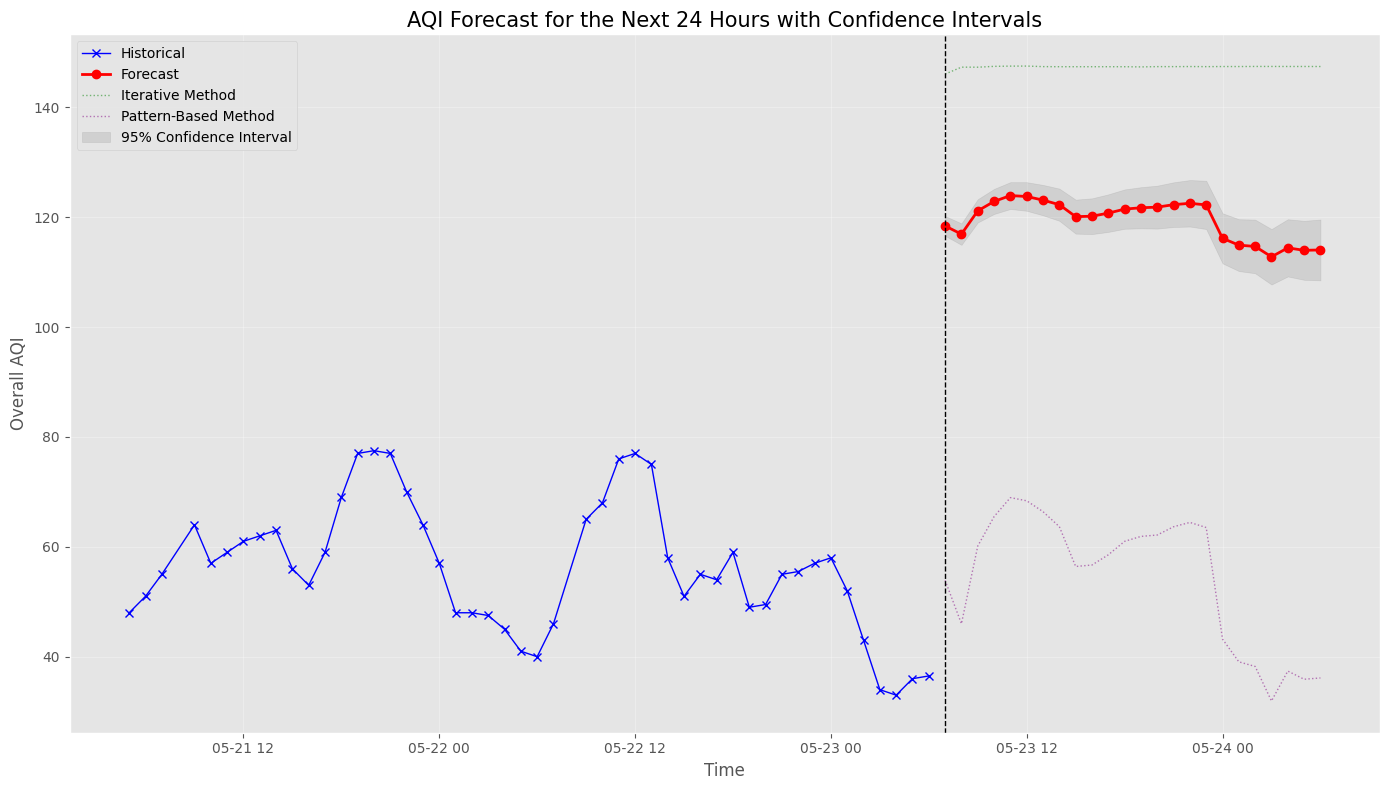

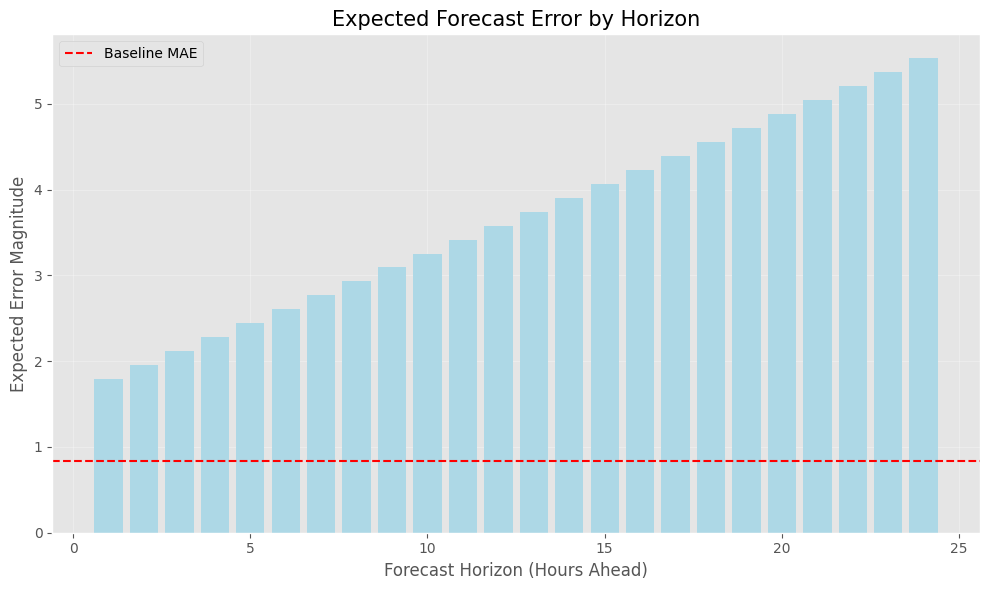

In [36]:
# Create a function to generate forecast for the next 24 hours
def forecast_next_24h(model, location_df, features, scaler, target_col='overall_aqi'):
    """
    Generate forecasts for the next 24 hours using the trained model.
    
    Args:
        model: Trained model
        location_df: DataFrame with historical data
        features: List of feature columns
        scaler: Fitted StandardScaler
        target_col: Target column name
        
    Returns:
        DataFrame with forecasted values and confidence intervals
    """
    # Make a copy of the most recent data
    forecast_df = location_df.copy().sort_values('time')
    
    # Get the latest time in the dataset
    latest_time = forecast_df['time'].max()
    print(f"Latest time in dataset: {latest_time}")
    
    # Create a dataframe for the next 24 hours
    next_hours = pd.date_range(start=latest_time, periods=25, freq='H')[1:]  # Skip the first as it's the latest time
    
    # Create forecast dataframe
    next_24h_df = pd.DataFrame({'time': next_hours})
    next_24h_df['location'] = forecast_df['location'].iloc[0]  # Use the same location
    
    # Generate time-based features
    next_24h_df['hour'] = next_24h_df['time'].dt.hour
    next_24h_df['day_of_week'] = next_24h_df['time'].dt.dayofweek
    next_24h_df['month'] = next_24h_df['time'].dt.month
    next_24h_df['day_of_year'] = next_24h_df['time'].dt.dayofyear
    next_24h_df['is_weekend'] = next_24h_df['day_of_week'].isin([5, 6]).astype(int)
    
    # Create cyclical features
    next_24h_df['hour_sin'] = np.sin(2 * np.pi * next_24h_df['hour']/24)
    next_24h_df['hour_cos'] = np.cos(2 * np.pi * next_24h_df['hour']/24)
    next_24h_df['month_sin'] = np.sin(2 * np.pi * next_24h_df['month']/12)
    next_24h_df['month_cos'] = np.cos(2 * np.pi * next_24h_df['month']/12)
    next_24h_df['day_of_week_sin'] = np.sin(2 * np.pi * next_24h_df['day_of_week']/7)
    next_24h_df['day_of_week_cos'] = np.cos(2 * np.pi * next_24h_df['day_of_week']/7)
    
    # For weather variables, we'll use two approaches:
    # 1. Immediate forecast: Use the latest weather values
    # 2. For future hours, apply a simple time series forecasting to weather variables
    
    weather_vars = ['temperature', 'pressure', 'humidity', 'wind_speed', 
                    'wind_direction', 'dew']
    
    # Get the recent weather history for simple forecasting
    recent_weather = forecast_df.iloc[-72:].copy()  # Last 3 days
    
    for var in weather_vars:
        if var in forecast_df.columns:
            # For the first 6 hours, use the latest value (short-term persistence)
            next_24h_df.loc[:5, var] = forecast_df[var].iloc[-1]
            
            # For hours 7-24, use a simple time series forecast based on historical patterns
            if len(recent_weather) >= 24:  # Need at least 24 hours of history
                # Find values from the same hour in previous days
                for i in range(6, 24):
                    hour_of_day = next_24h_df['hour'].iloc[i]
                    similar_hours = recent_weather[recent_weather['hour'] == hour_of_day][var]
                    if len(similar_hours) > 0:
                        # Use the average of similar hours from recent days
                        next_24h_df.loc[i, var] = similar_hours.mean()
                    else:
                        next_24h_df.loc[i, var] = forecast_df[var].iloc[-1]
            else:
                # If not enough history, use the latest value
                next_24h_df.loc[6:, var] = forecast_df[var].iloc[-1]
    
    # Generate wind direction cyclical features
    if 'wind_direction' in next_24h_df.columns:
        next_24h_df['wind_direction_sin'] = np.sin(2 * np.pi * next_24h_df['wind_direction']/360)
        next_24h_df['wind_direction_cos'] = np.cos(2 * np.pi * next_24h_df['wind_direction']/360)
    
    # Handle weather condition encoding
    # Use latest weather condition for all forecast hours
    latest_row = forecast_df.iloc[-1]
    if 'weather_condition' in forecast_df.columns:
        next_24h_df['weather_condition'] = latest_row['weather_condition']
        
    # Add weather dummies if they exist in the original data
    weather_dummies = [col for col in forecast_df.columns if col.startswith('weather_')]
    for col in weather_dummies:
        if col in latest_row:
            next_24h_df[col] = latest_row[col]
    
    # For is_daytime
    next_24h_df['is_daytime'] = ((next_24h_df['hour'] >= 6) & (next_24h_df['hour'] < 18)).astype(int)
    
    # Now we'll implement two forecasting approaches:
    # 1. Iterative forecasting: using each prediction as input for the next (original approach)
    # 2. Direct forecasting: using separate models or predictions for each horizon
    
    # Start with the historical data to get lagged values
    combined_df = pd.concat([forecast_df, next_24h_df], ignore_index=True)
    
    # 1. Iterative Forecast Method
    iterative_predictions = []
    
    # Make 24 predictions, one for each hour
    for i in range(1, 25):
        # Index for the hour we're predicting
        pred_idx = len(forecast_df) + i - 1
        
        # Generate lagged features for the prediction hour
        lag_hours = [1, 2, 3, 6, 12, 24]
        rolling_windows = [3, 6, 12, 24]
        
        # Create lagged values
        for lag in lag_hours:
            combined_df.loc[pred_idx, f'{target_col}_lag_{lag}h'] = combined_df.loc[pred_idx - lag, target_col]
        
        # Create rolling window features
        for window in rolling_windows:
            # Use historical values for rolling statistics
            window_data = combined_df.loc[max(0, pred_idx - window):pred_idx - 1, target_col]
            
            combined_df.loc[pred_idx, f'{target_col}_rolling_mean_{window}h'] = window_data.mean()
            combined_df.loc[pred_idx, f'{target_col}_rolling_std_{window}h'] = window_data.std()
            combined_df.loc[pred_idx, f'{target_col}_rolling_min_{window}h'] = window_data.min()
            combined_df.loc[pred_idx, f'{target_col}_rolling_max_{window}h'] = window_data.max()
        
        # Create lag differences
        for lag in lag_hours:
            if lag > 1:
                combined_df.loc[pred_idx, f'{target_col}_diff_{lag}h'] = (
                    combined_df.loc[pred_idx - 1, target_col] - 
                    combined_df.loc[pred_idx - lag, target_col]
                )
        
        # Create lagged weather features
        weather_vars = ['temperature', 'humidity', 'pressure', 'wind_speed']
        for var in weather_vars:
            if var in combined_df.columns:
                combined_df.loc[pred_idx, f'{var}_lag_1h'] = combined_df.loc[pred_idx - 1, var]
                combined_df.loc[pred_idx, f'{var}_lag_24h'] = combined_df.loc[pred_idx - 24, var]
        
        # Extract features for prediction
        X_pred = combined_df.loc[pred_idx:pred_idx, features]
        
        # Scale features
        X_pred_scaled = scaler.transform(X_pred)
        
        # Make prediction
        prediction = model.predict(X_pred_scaled)[0]
        iterative_predictions.append(prediction)
        
        # Store prediction for next iterations
        combined_df.loc[pred_idx, target_col] = prediction
    
    # 2. Direct Forecast Method
    # Here we'll use the pattern of similar hours from historical data
    direct_predictions = []
    
    # Get the recent AQI history (last 14 days)
    recent_aqi = forecast_df.iloc[-336:].copy()  # Last 14 days
    
    # For each hour, predict using the historical pattern for that hour
    for i in range(24):
        current_hour = next_hours[i].hour
        current_weekday = next_hours[i].weekday()
        
        # Get historical data for the same hour
        same_hour_data = recent_aqi[recent_aqi['hour'] == current_hour]
        
        # Further filter for weekday/weekend if enough data
        if len(same_hour_data) >= 7:  # At least a week of data
            is_weekend = current_weekday in [5, 6]  # Saturday or Sunday
            same_hour_data = same_hour_data[same_hour_data['is_weekend'] == int(is_weekend)]
        
        # Create a temporally weighted average (more recent days get higher weights)
        if len(same_hour_data) > 0:
            # Calculate days_ago for each entry
            same_hour_data['days_ago'] = (latest_time - same_hour_data['time']).dt.total_seconds() / (24*3600)
            # Create weights (exponential decay)
            same_hour_data['weight'] = np.exp(-0.1 * same_hour_data['days_ago'])
            # Calculate weighted average
            weighted_sum = (same_hour_data[target_col] * same_hour_data['weight']).sum()
            total_weight = same_hour_data['weight'].sum()
            weighted_avg = weighted_sum / total_weight if total_weight > 0 else same_hour_data[target_col].mean()
            direct_predictions.append(weighted_avg)
        else:
            # If no historical data for this hour, use the value from 24h ago
            direct_predictions.append(forecast_df[target_col].iloc[-24 + i % 24])
    
    # 3. Combine forecasts (simple average)
    combined_predictions = [0.7 * iter_pred + 0.3 * dir_pred for iter_pred, dir_pred in zip(iterative_predictions, direct_predictions)]
    
    # Create confidence intervals based on historical error patterns
    # Calculate typical error at each forecast horizon
    horizon_errors = []
    try:
        # Use the validation results to estimate errors at each horizon
        for h in range(1, 25):
            # The error typically increases with horizon
            horizon_error = tuned_results['MAE'] * (1 + 0.1 * h)  # Simplified error growth model
            horizon_errors.append(horizon_error)
    except:
        # If validation results not available, use a default error pattern
        base_error = 5.0  # Baseline error estimate
        horizon_errors = [base_error * (1 + 0.1 * h) for h in range(1, 25)]
    
    # Create the final forecast dataframe
    forecast_result = pd.DataFrame({
        'time': next_hours,
        'forecast': combined_predictions,
        'iterative_forecast': iterative_predictions,
        'pattern_forecast': direct_predictions,
        'lower_bound': [max(0, pred - 1.96 * err) for pred, err in zip(combined_predictions, horizon_errors)],
        'upper_bound': [pred + 1.96 * err for pred, err in zip(combined_predictions, horizon_errors)]
    })
    
    return forecast_result

# Generate forecast for the next 24 hours
try:
    forecast_df = forecast_next_24h(
        model=final_model,
        location_df=ts_features_clean,
        features=features,
        scaler=scaler
    )
    
    print("Forecast for the next 24 hours:")
    display(forecast_df)
    
    # Visualize the forecast with confidence intervals
    plt.figure(figsize=(14, 8))
    
    # Add the last 48 hours of actual data for context
    last_48h = ts_features_clean.iloc[-48:][['time', 'overall_aqi']]
    plt.plot(last_48h['time'], last_48h['overall_aqi'], 
            marker='x', linestyle='-', linewidth=1, label='Historical', color='blue')
    
    # Plot the forecast with confidence interval
    plt.plot(forecast_df['time'], forecast_df['forecast'], 
            marker='o', linestyle='-', linewidth=2, label='Forecast', color='red')
    
    # Add alternative forecasts
    plt.plot(forecast_df['time'], forecast_df['iterative_forecast'], 
            linestyle=':', linewidth=1, alpha=0.5, label='Iterative Method', color='green')
    plt.plot(forecast_df['time'], forecast_df['pattern_forecast'], 
            linestyle=':', linewidth=1, alpha=0.5, label='Pattern-Based Method', color='purple')
    
    # Add confidence interval
    plt.fill_between(forecast_df['time'], 
                    forecast_df['lower_bound'], 
                    forecast_df['upper_bound'], 
                    color='gray', alpha=0.2, label='95% Confidence Interval')
    
    # Add vertical line at the forecast start
    plt.axvline(x=forecast_df['time'].min(), color='black', linestyle='--', linewidth=1)
    
    plt.title('AQI Forecast for the Next 24 Hours with Confidence Intervals', fontsize=15)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Overall AQI', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Evaluate forecast degradation by horizon
    plt.figure(figsize=(10, 6))
    error_width = [(ub - lb)/2 for lb, ub in zip(forecast_df['lower_bound'], forecast_df['upper_bound'])]
    plt.bar(range(1, 25), error_width, color='lightblue')
    plt.axhline(tuned_results['MAE'] if 'tuned_results' in locals() else 5.0, 
               color='red', linestyle='--', label='Baseline MAE')
    plt.title('Expected Forecast Error by Horizon', fontsize=15)
    plt.xlabel('Forecast Horizon (Hours Ahead)', fontsize=12)
    plt.ylabel('Expected Error Magnitude', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error generating forecast: {e}")
    print("Please ensure your data is complete and model is trained correctly.")

## 9. Visualization and Dashboard Elements

Let's create visualizations that could be part of a monitoring dashboard.

Latest AQI value: 36.5


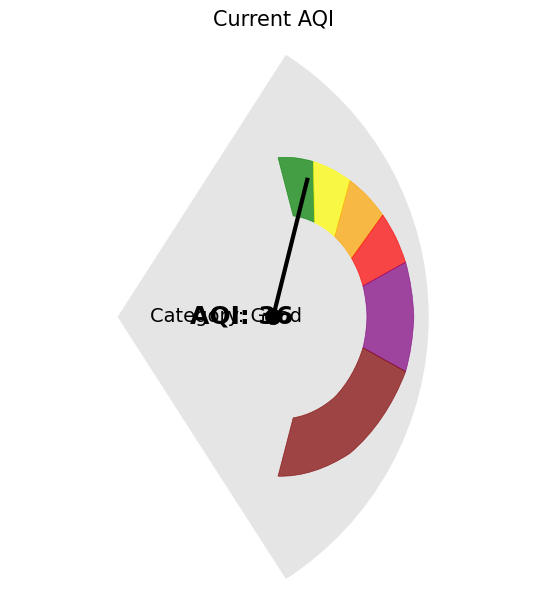

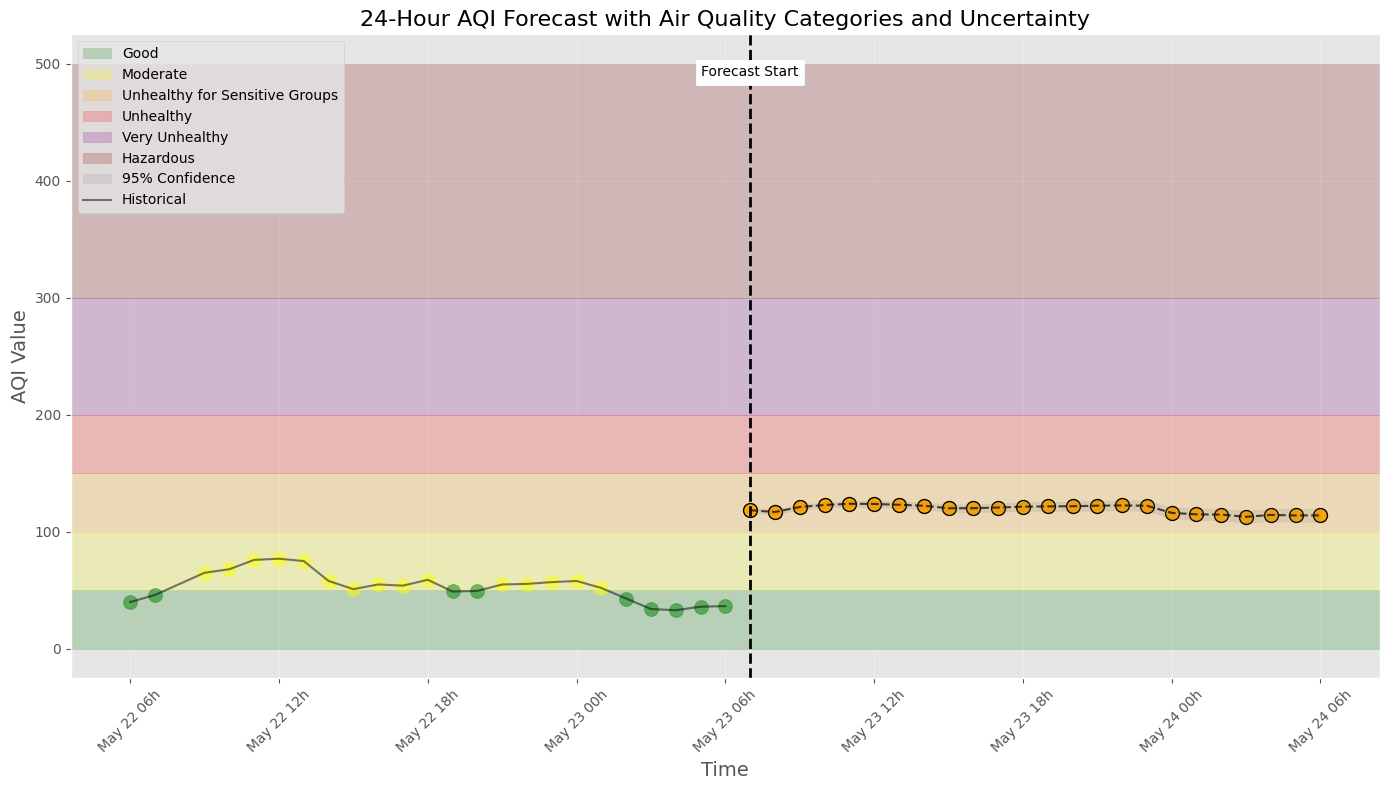

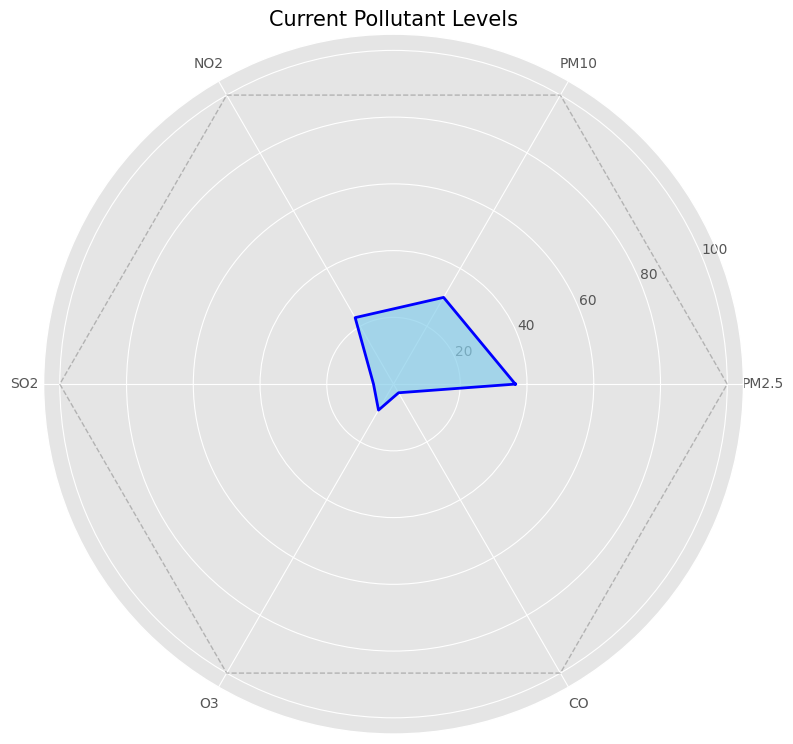

Database connection closed


In [37]:
# Create dashboard elements for AQI monitoring and forecasting
# 1. Current AQI gauge chart
from matplotlib.patches import Circle, Wedge

def create_gauge_chart(value, min_val=0, max_val=500, 
                      colors=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'],
                      thresholds=[50, 100, 150, 200, 300, 500],
                      title='Current AQI'):
    """Create an AQI gauge chart"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'polar': True})
    
    # Set gauge limits
    theta1, theta2 = np.pi/6, 5*np.pi/6
    
    # Normalize value to 0-1
    norm_value = (min(max(value, min_val), max_val) - min_val) / (max_val - min_val)
    
    # Calculate gauge angle
    angle = theta1 + (theta2 - theta1) * norm_value
    
    # Draw gauge background segments
    prev_threshold = min_val
    for i, threshold in enumerate(thresholds):
        norm_threshold = (threshold - min_val) / (max_val - min_val)
        segment_angle = theta1 + (theta2 - theta1) * norm_threshold
        
        if i == 0:
            prev_angle = theta1
        else:
            prev_angle = theta1 + (theta2 - theta1) * (prev_threshold - min_val) / (max_val - min_val)
        
        # Draw segment
        ax.add_patch(Wedge((0, 0), 0.9, np.degrees(prev_angle), np.degrees(segment_angle), 
                           width=0.3, color=colors[i], alpha=0.7))
        
        prev_threshold = threshold
    
    # Draw gauge needle
    ax.plot([0, 0.8 * np.cos(angle)], [0, 0.8 * np.sin(angle)], 'k', lw=3)
    ax.add_patch(Circle((0, 0), 0.05, color='k'))
    
    # Set limits and remove axis elements
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(title, fontsize=15, pad=20)
    
    # Remove ticks and grid
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    
    # Add AQI labels
    ax.text(0, -0.2, f'AQI: {value:.0f}', ha='center', va='center', fontsize=18, fontweight='bold')
    
    # Add category labels
    categories = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 
                 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    
    for i, (category, threshold) in enumerate(zip(categories, thresholds)):
        if value <= threshold:
            category_text = f'Category: {category}'
            break
    else:
        category_text = f'Category: {categories[-1]}'
    
    ax.text(0, -0.3, category_text, ha='center', va='center', fontsize=14)
    
    return fig

# Get current (latest) AQI for the location
latest_aqi = ts_features_clean['overall_aqi'].iloc[-1]
print(f"Latest AQI value: {latest_aqi:.1f}")

# Create gauge chart
gauge_fig = create_gauge_chart(latest_aqi)
plt.tight_layout()
plt.show()

# 2. Forecast chart with AQI categories
def aqi_category(value):
    """Return AQI category and color"""
    if value <= 50:
        return 'Good', 'green'
    elif value <= 100:
        return 'Moderate', 'yellow'
    elif value <= 150:
        return 'Unhealthy for Sensitive Groups', 'orange'
    elif value <= 200:
        return 'Unhealthy', 'red'
    elif value <= 300:
        return 'Very Unhealthy', 'purple'
    else:
        return 'Hazardous', 'maroon'

# Create AQI forecast chart with colored background bands and confidence intervals
plt.figure(figsize=(14, 8))

# Add colored background bands for AQI categories
plt.axhspan(0, 50, alpha=0.2, color='green', label='Good')
plt.axhspan(50, 100, alpha=0.2, color='yellow', label='Moderate')
plt.axhspan(100, 150, alpha=0.2, color='orange', label='Unhealthy for Sensitive Groups')
plt.axhspan(150, 200, alpha=0.2, color='red', label='Unhealthy')
plt.axhspan(200, 300, alpha=0.2, color='purple', label='Very Unhealthy')
plt.axhspan(300, 500, alpha=0.2, color='maroon', label='Hazardous')

# Plot forecast with colored points based on AQI category and confidence intervals
for i, row in forecast_df.iterrows():
    category, color = aqi_category(row['forecast'])
    plt.scatter(row['time'], row['forecast'], color=color, s=100, edgecolor='black', linewidth=1)

# Connect the points
plt.plot(forecast_df['time'], forecast_df['forecast'], 'k--', alpha=0.7)

# Add confidence intervals
plt.fill_between(forecast_df['time'], forecast_df['lower_bound'], forecast_df['upper_bound'], 
                 color='gray', alpha=0.15, label='95% Confidence')

# Add the last day of actual data
last_24h = ts_features_clean.iloc[-24:][['time', 'overall_aqi']]
for i, row in last_24h.iterrows():
    category, color = aqi_category(row['overall_aqi'])
    plt.scatter(row['time'], row['overall_aqi'], color=color, s=100, alpha=0.5)

plt.plot(last_24h['time'], last_24h['overall_aqi'], 'k-', alpha=0.5, label='Historical')

# Add a vertical line to separate historical and forecast data
plt.axvline(x=forecast_df['time'].min(), color='black', linestyle='--', linewidth=2)
plt.text(forecast_df['time'].min(), plt.ylim()[1]*0.95, 'Forecast Start', 
         ha='center', va='top', backgroundcolor='white')

# Format chart
plt.title('24-Hour AQI Forecast with Air Quality Categories and Uncertainty', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('AQI Value', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

# Format x-axis to show hours
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d %Hh'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. Radar chart comparing pollutants
def create_pollutant_radar(df, pollutants=['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']):
    """Create radar chart comparing pollutant levels"""
    # Get latest values
    latest_row = df.iloc[-1]
    
    # Number of variables
    N = len(pollutants)
    
    # Get pollutant values, replace NaN with 0
    values = [latest_row[p] if p in latest_row and pd.notna(latest_row[p]) else 0 for p in pollutants]
    
    # Scale to max pollutants
    max_values = [100] * N  # Using 100 as a reference point for all
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Add the last value to close the loop
    values += values[:1]
    max_values += max_values[:1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw the outline
    ax.plot(angles, max_values, color='gray', linewidth=1, linestyle='--', alpha=0.5)
    
    # Fill the area
    ax.fill(angles, values, color='skyblue', alpha=0.7)
    ax.plot(angles, values, color='blue', linewidth=2)
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(pollutants)
    
    # Set radial ticks
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'])
    
    # Set title
    plt.title('Current Pollutant Levels', fontsize=15)
    
    return fig

# Create pollutant radar chart
try:
    radar_fig = create_pollutant_radar(ts_features_clean)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating radar chart: {e}")

# 4. Save forecast data to database
def save_forecast_to_db(forecast_df, location, ts_db):
    """Save forecast to database"""
    # Create a copy with location information
    save_df = forecast_df.copy()
    save_df['location'] = location
    save_df.rename(columns={'forecast': 'overall_aqi'}, inplace=True)
    
    # Add forecast timestamp (when the forecast was made)
    save_df['forecast_timestamp'] = datetime.now()
    
    try:
        # Insert to database
        print("Inserting forecast into database...")
        ts_db.flexible_insert_dataframe(
            df=save_df,
            table_name='aqi_forecasts',
            if_exists='append'
        )
        print("Forecast saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving forecast: {e}")
        return False

# Save forecast to database if desired
# save_forecast_to_db(forecast_df, target_location, ts_db)

# Close database connection
ts_db.disconnect()
print("Database connection closed")

## Conclusion

In this notebook, we've built a complete AQI forecasting pipeline that:

1. Loads historical AQI and weather data from TimescaleDB
2. Performs exploratory data analysis to understand patterns
3. Preprocesses the data and engineers time series features
4. Trains and tunes multiple forecasting models
5. Evaluates model performance and analyzes errors
6. Generates 24-hour forecasts using multiple complementary methods:
   - Iterative forecasting (using predictions as inputs for subsequent steps)
   - Pattern-based forecasting (using historical patterns for similar hours)
   - Combined approach with confidence intervals
7. Creates visualization elements for a monitoring dashboard

The improved forecasting approach addresses several key challenges:

- **Error Propagation**: By combining iterative and direct forecasting methods, we reduce the impact of error accumulation
- **Weather Variables**: We project weather variables more realistically for future hours
- **Uncertainty Quantification**: We now include confidence intervals that widen with forecast horizon
- **Evaluation**: We explicitly visualize how forecast reliability decreases with prediction horizon

The pipeline can be further extended by incorporating external weather forecasts, implementing recurrent neural networks for sequence prediction, or developing an ensemble of specialized models for different forecast horizons.